# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
# 基本的なライブラリ
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [2]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [3]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [4]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [5]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    # display(_X_train.shape, _y_train.shape)
    # display(_X_test.shape, _y_test.shape)
    if _X_train.shape[0] < 20:
        return

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-index
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    _risk_test = _model_pipeline.predict(_X_test)
    print(_risk_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    # cumulative/dynamic auc
    _cph_auc, _cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    print(_cph_mean_auc)

    # 累積AUCの表示
    plt.subplot(1, 1, 1)
    plt.plot(va_times, _cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    """
    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )
    """

    df_score = pd.DataFrame(
        [_train_score, _test_score, _cph_mean_auc],
        index=[
            "train c-index",
            "test c-index",
            "AUC mean",
        ],  # "Integrated Brier Score"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

_cph_auc:
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 1.         1.
 1.         1.         0.63044534 0.63044534 0.63044534 0.63044534
 0.63044534 0.63044534 0.63044534 0.63044534 0.63044534 0.63044534
 0.63044534 0.63044534 0.63044534 0.63044534 0.63044534 0.63044534
 0.63044534 0.63044534 0.63044534 0.63044534 0.63044534 0.57181195
 0.61675231 0.61675231 0.61675231 0.61675231 0.61675231 0.61675231
 0.61675231 0.61675231 0.57282045 0.57282045 0.57282045 0.57282045
 0.57282045 0.57282045 0.57282045 0.57282045 0.57282045 0.57282045
 0.57282045 0.57556627 0.59333271 0.59333271 0.59333271 0.59333271
 0.59333271 0.59333271 0.59333271 0.59333271 0.59333271 0.59333271
 0.59333271 0.56205062 0.56205062 0.56205062 0.56205062 0.56205062
 0.59557746 0.59557746 0.59557746 0.59557746 0.59557746 0.59557746
 0.59557746 0.59557746 0.59557746 0.59557746 0.55881177 0.55

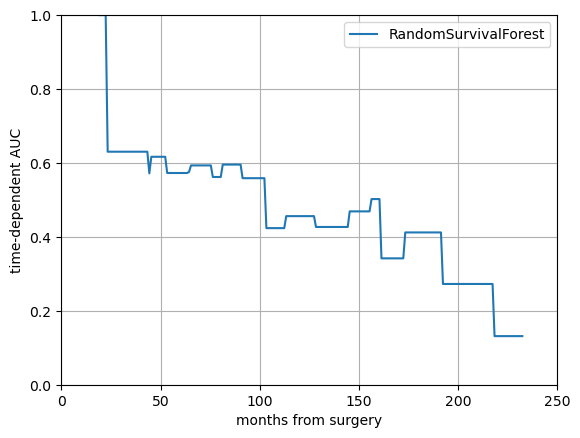

In [14]:
#AUC等の動作を関数から切り離して見たい

from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

model_order: dict = {"original_data": []},
val_step= "test_set"
output_pipe_path: str = None,
is_fitted: bool = False,


subgroup_column = "CLAUDIN_SUBTYPE"
subgroup = "claudin-low"
#subgroup = "Basal"

input_data_path = "./{0}/{1}/{2}/{3}".format(
config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
subgroup_column,
subgroup,
"NEWpreprocess4numeric_Incpca5",
)

output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
    config.INTERIM_MODELS_RECURRENCE_DIR,
    subgroup_column,
    subgroup,
    "NEWpreprocess4numeric_Incpca5",
    "RandomSurvivalForest",
)
try:
    _X_train = pd.read_pickle(
        "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
    )
    _y_train = pd.read_pickle(
        "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
    ).to_records(index=False)
    _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
    _y_test = pd.read_pickle(
        "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
    ).to_records(index=False)
except:
    print("data pkl file dose not exist")

pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)

if exists_pipeline(pipeline_path) and is_fitted:
    # 学習済みパイプラインの使用
    _model_pipeline = functions.pickle_load(
        "{0}/model_pipeline.pkl".format(pipeline_path)
    )
else:
    # パイプラインの学習の実施
    _model_pipeline = Pipeline(steps=model_order)
    _model_pipeline.fit(_X_train, _y_train)
_estimator = _model_pipeline[-1]

# c-index
_train_score = _estimator.score(_X_train, _y_train)
_test_score = _estimator.score(_X_test, _y_test)

_risk_test = _model_pipeline.predict(_X_test)
#print(_risk_test)
va_times = np.arange(
    pd.DataFrame(_y_test).RFS_MONTHS.min(),
    pd.DataFrame(_y_test).RFS_MONTHS.max(),
    1,
)
# cumulative/dynamic auc
_cph_auc, _cph_mean_auc = cumulative_dynamic_auc(
    _y_train, _y_test, _risk_test, va_times
)
print("_cph_auc:")
print(_cph_auc)
c = np.mean(_cph_auc)
print("AUCの平均値:np.mean(_cph_auc):")
print(c)
#print("va_times:")
#print(va_times)

# 累積AUCの表示
plt.subplot(1, 1, 1)
plt.plot(va_times, _cph_auc, label=_estimator.__class__.__name__)
plt.xlabel("months from surgery")
plt.ylabel("time-dependent AUC")
plt.xlim(0, 250)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

print("関数の返り値_cph_mean_auc:")
print(_cph_mean_auc)

In [91]:
"""
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"
    
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            # print("subgroup: ", subgroup)
            # init each loop
            plt.figure(figsize=(6, 6))
            df_scores = pd.DataFrame(
                index=["train c-index", "test c-index", "AUC mean"]
            )

            for model_order_dict in model_order_dicts:
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                df_score = validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_pipe_path=output_pipe_path,
                    is_fitted=False,
                )
                df_scores = pd.merge(
                    df_scores, df_score, right_index=True, left_index=True
                )

            try:
                output_result_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                functions.make_dir(output_result_path)
                df_scores.to_csv(output_result_path + "/result.csv")
            except:
                pass

            output_fig_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            functions.make_dir(output_fig_path)
            # plt.close()
            plt.title(subgroup)
            plt.savefig(output_fig_path + "/auc.png")
            plt.show();
"""

'\ndef loop_exec():\n    # 層別化する特徴量\n    subgroup_columns = [\n        "CLAUDIN_SUBTYPE",\n        # "THREEGENE",\n    ]\n    # 遺伝子発現量以外の特徴量を削除\n    drop_columns = [\n        "CLAUDIN_SUBTYPE",\n        "THREEGENE",\n    ]\n\n    val_step = "test_set"\n    \n    for subgroup_column in subgroup_columns:  # 各サブグループへの適用\n        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用\n            # print("subgroup: ", subgroup)\n            # init each loop\n            plt.figure(figsize=(6, 6))\n            df_scores = pd.DataFrame(\n                index=["train c-index", "test c-index", "AUC mean"]\n            )\n\n            for model_order_dict in model_order_dicts:\n                input_data_path = "./{0}/{1}/{2}/{3}".format(\n                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,\n                    subgroup_column,\n                    subgroup,\n                    model_order_dict["preprocess_name"],\n                )\n                output_pi

In [10]:
def loop_exec():
    # 層別化する特徴量
    subgroup_column = "CLAUDIN_SUBTYPE"
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"
    
    subgroup = "claudin-low"
 
    # print("subgroup: ", subgroup)
    # init each loop
    plt.figure(figsize=(6, 6))
    df_scores = pd.DataFrame(
        index=["train c-index", "test c-index", "AUC mean"]
    )

    for model_order_dict in model_order_dicts:
        input_data_path = "./{0}/{1}/{2}/{3}".format(
            config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
        )
        output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
            config.INTERIM_MODELS_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
            model_order_dict["model_name"],
        )
        df_score = validate_model(
            model_order=model_order_dict["model_order"],
            val_step=val_step,
            input_data_path=input_data_path,
            output_pipe_path=output_pipe_path,
            is_fitted=False,
        )
        df_scores = pd.merge(
            df_scores, df_score, right_index=True, left_index=True
        )

    try:
        output_result_path = "./{0}/{1}/{2}/{3}".format(
            config.INTERIM_MODELS_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
        )
        functions.make_dir(output_result_path)
        df_scores.to_csv(output_result_path + "/result.csv")
    except:
        pass

    output_fig_path = "./{0}/{1}/{2}/{3}".format(
        config.FIGURES_MODELS_RECURRENCE_DIR,
        subgroup_column,
        subgroup,
        model_order_dict["preprocess_name"],
    )
    functions.make_dir(output_fig_path)
    # plt.close()
    plt.title(subgroup)
    plt.savefig(output_fig_path + "/auc.png")
    plt.show();

  0%|                                                                                            | 0/65 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
100
[-0.03735158 -0.96206756  0.50051481  0.51130983  0.00917246 -0.22984632
  0.25743864  0.41897574  0.15406213  0.07266686 -1.10421013 -0.53910777
  0.51981256  0.458765    0.20014335  0.0658485  -0.40942608 -0.78536508
 -0.01494377 -0.99761156 -0.54514762  0.26385473]
nan
[-1.00677013 -1.34322865  0.74421216 -0.26515913 -1.77944035 -2.33733824
 -0.821373    0.21926864 -1.22940714 -1.90253402 -1.1656388  -2.76519153
  0.37539347  1.07026266 -1.67826814 -2.65235806 -0.94247894 -2.81029772
 -3.24557965 -3.13970537 -2.33678473 -2.76512594]
nan
[11.24741753  8.43102093 12.1815097  11.96354517  9.363404    9.34368817
 11.02850574 11.19176296  9.26488131 10.61064856 10.06591592  8.92811636
 11.39516578 12.29145448 10.57780168  8.79653254 10.48753463  7.9446097
  8.8206363   8.2310782   9.49288369  7.66445994]
nan
[11.29592137 10.56034831 11.81234255 11.51534088 10.56011146 11.31797885
 11.

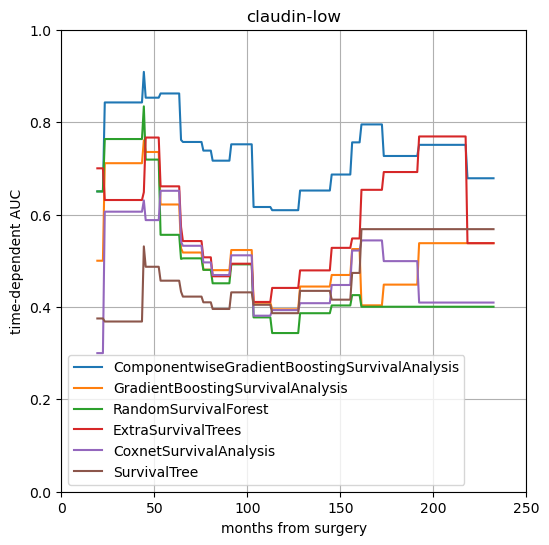

  2%|█▏                                                                               | 1/65 [02:21<2:31:07, 141.68s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
101
[ 0.01954006 -0.91878416  0.5398254   0.50905296  0.01251702 -0.19188295
  0.33127619  0.39909134  0.17546502  0.13515842 -1.01236401 -0.66269456
  0.52242372  0.46718364  0.1637546   0.05022228 -0.43060128 -0.78171727
 -0.05312646 -1.01604736 -0.57553528  0.29752655]
nan
[-0.92852824 -1.07083921  0.90119673  0.19215637 -1.68989963 -2.14296662
 -0.66254398  0.1374932  -0.9103617  -1.50402447 -0.33617352 -2.87058449
  0.46432058  1.26149568 -2.09154973 -2.10881371 -0.49932645 -2.77302794
 -3.11656668 -2.72004335 -2.03672849 -2.281307  ]
nan
[11.54698497  8.19215743 11.97890283 12.2715636   9.36873234  9.39754069
 11.81380496 11.26394129  9.7495137  11.50570576 10.56412761  8.4356836
 11.45128628 12.38247719 10.37775064  8.41224611 10.94389946  7.59747298
  9.73903171  8.54088252  9.60666507  7.3296709 ]
nan
[11.32157125 10.85088562 11.80757022 11.66690363 10.9285734  11.49765953
 11.

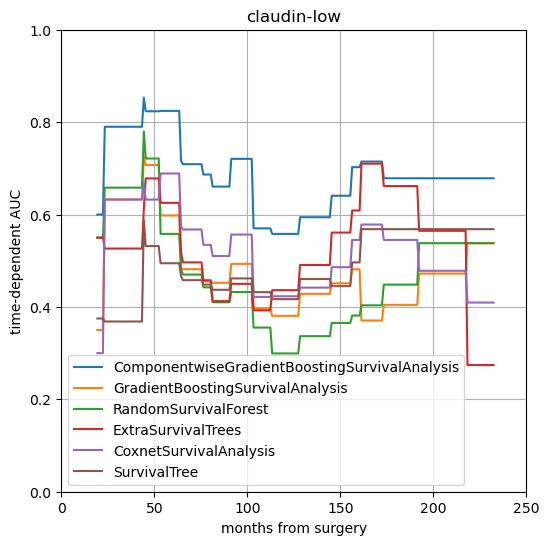

  3%|██▍                                                                              | 2/65 [04:42<2:28:09, 141.10s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
102
[ 0.0187934  -0.9076468   0.55322446  0.48984912  0.04316197 -0.20824102
  0.34119614  0.40382994  0.16901052  0.14496076 -1.01209963 -0.64362584
  0.53126142  0.47638072  0.15158734  0.01633658 -0.41164115 -0.74927096
 -0.03992068 -1.04258374 -0.53699641  0.24909516]
nan
[-1.15707383 -1.32292375  0.81047722  0.04508856 -1.57322605 -2.02905254
 -0.63963266  0.57368234 -1.19711992 -1.3637039  -0.51381899 -3.2181923
  0.48442439  0.42791492 -2.58086101 -2.04065235 -0.45536562 -2.76279639
 -3.26149951 -2.74492457 -2.22222527 -2.63993723]
nan
[11.24017103  8.11730417 12.34201211 12.28049786  8.83776994 10.04983102
 11.57844049 11.62246399  9.9909229  10.68819225  9.7190716   9.04544252
 11.35812469 12.09772411 10.38644752  8.77525826 10.49281485  7.84606355
  8.97955307  8.84782165  9.89696603  7.3623319 ]
nan
[11.50027447 11.09419186 12.1524645  11.79292688 10.91556803 11.37480606
 11.

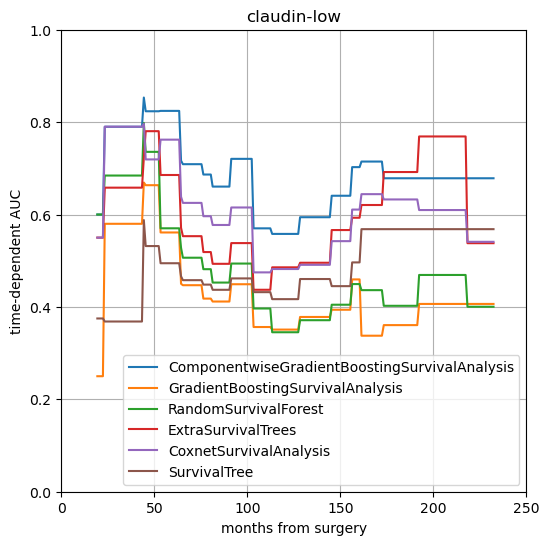

  5%|███▋                                                                             | 3/65 [07:04<2:26:19, 141.60s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
103
[ 0.06833519 -0.87634457  0.47875822  0.35964556  0.16104117 -0.17454125
  0.26012392  0.37278111  0.12479293  0.10202599 -0.99836849 -0.49634421
  0.59741802  0.45422083  0.17968052  0.07086606 -0.41709043 -0.81355478
 -0.10092788 -0.99167988 -0.77232456  0.22822032]
nan
[-1.5576007  -0.74270302 -0.56657063 -0.42169515 -1.4743723  -2.22041095
 -1.17077427 -0.42620647 -2.26330739 -2.04280599 -1.59753984 -2.70841076
 -0.86774877 -0.89812271 -1.97745151 -1.48373414 -1.14847924 -3.32996746
 -3.36334121 -2.42056847 -2.35392119 -1.98690912]
nan
[11.01063614  9.51740383 11.92616732 11.80077396 10.05465107  9.5986487
 10.79826802 12.17254844  9.42294582 10.00888039  9.73725691  9.28555405
 10.67136582 11.50018735  9.81586082  9.06136533 10.84932682  7.27108427
  8.34694338  8.13808911  9.43408039  7.99100969]
nan
[11.40283398 10.90847518 12.39064935 11.62666493 11.37143936 11.69747673
 11.

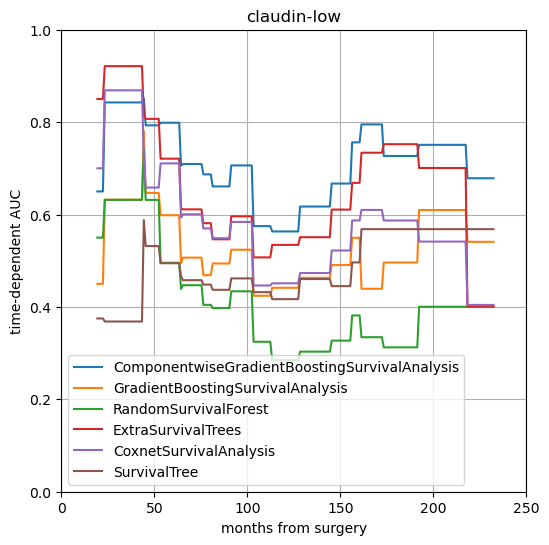

  6%|████▉                                                                            | 4/65 [09:26<2:24:10, 141.81s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
104
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.04752954 -1.00173905 -0.12081011 -0.46906424 -1.08568476 -1.87962632
 -0.92174975  0.42268983 -2.00919864 -1.57637025 -0.95571444 -2.65388715
 -0.32860539 -0.3379057  -1.71923189 -1.64387752 -1.31842903 -3.17740786
 -2.99751025 -2.54641799 -2.2008635  -1.96303733]
nan
[10.92410279  8.68687005 11.89035571 12.49912346 10.19947931 10.2091566
 11.10996316 12.58147886  9.33735793 10.21419174  9.03804567  9.36128282
 10.96801183 12.67073507 10.56574176  9.80227495 10.69360275  7.41932442
  8.07822523  7.31727143  8.84332024  7.92380654]
nan
[11.94426847 11.17543863 12.11728706 11.35117234 11.26780362 11.5668181
 11.9

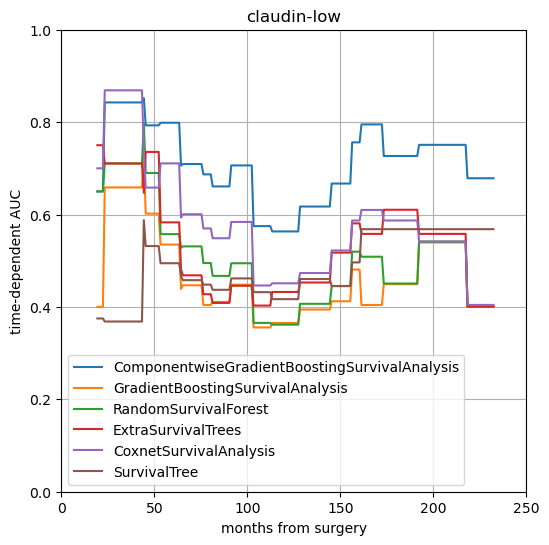

  8%|██████▏                                                                          | 5/65 [11:47<2:21:16, 141.27s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
105
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.48628081 -1.19740222 -0.33407407 -0.416363   -1.20500254 -1.95701626
 -1.09482512  0.34136226 -1.99582531 -1.79438879 -1.29585239 -2.73068974
 -0.48268489 -0.7161744  -1.79501713 -1.50830301 -1.0816952  -3.25674389
 -3.32802461 -2.45416704 -2.06983553 -2.06987496]
nan
[10.76975991  9.35013148 12.34352788 11.1901517  10.03817715 10.05496741
 10.83328622 12.12266883  9.60514188  9.65405087  9.49692965  9.11598983
 10.17999644 11.93642884  9.93787949  9.50681192 10.70893776  6.82026325
  8.64241998  7.99894053  8.54025082  7.7001257 ]
nan
[11.45615945 11.03742141 12.18999562 11.42430888 11.04992351 11.56805447
 12

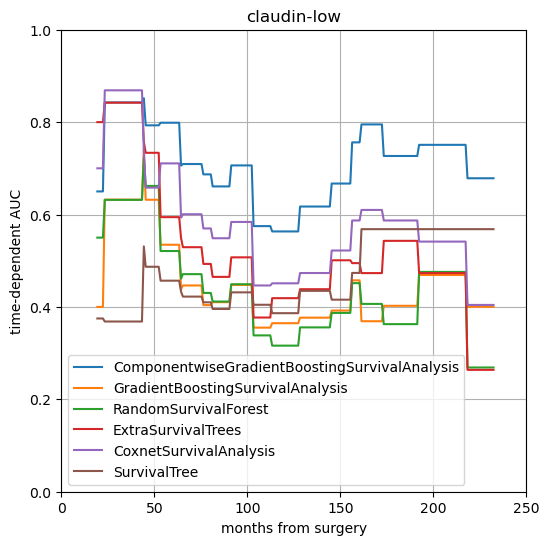

  9%|███████▍                                                                         | 6/65 [14:10<2:19:29, 141.86s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
106
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.30533613 -0.93244342 -0.20555884 -0.19128534 -1.00058491 -1.83813223
 -1.12993918  0.14957794 -1.67564723 -1.90217114 -1.10312302 -2.61792799
 -0.67176811 -0.57085851 -1.88189108 -1.42087528 -0.94874287 -3.09638829
 -3.2257728  -2.19988794 -2.0177632  -1.94972781]
nan
[10.53024672  9.03370821 12.28339532 11.68482772 10.23104097  9.95426298
 10.96539471 12.85727968  9.68694319 10.0474065   9.45034212  8.78820307
 10.05641464 11.44438157 10.07244056  9.70540176 10.81916807  7.542134
  8.63214894  8.01612325  9.53119111  8.55203007]
nan
[11.71477571 10.94910466 12.36381599 11.49210684 11.24561658 11.74279968
 12.0

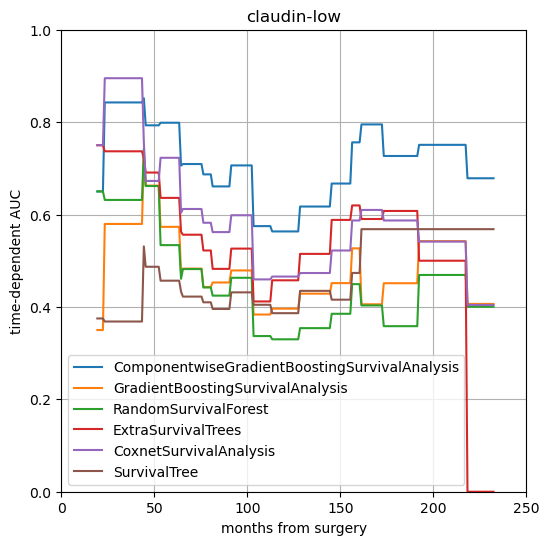

 11%|████████▋                                                                        | 7/65 [16:31<2:17:04, 141.79s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
107
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.3018706  -1.11650042 -0.34573174 -0.30424816 -1.11132508 -1.93783759
 -1.00231255  0.43770032 -1.91425584 -1.88844536 -1.03349463 -2.67082617
 -0.65079424 -0.619482   -1.76937075 -1.58832945 -0.78215168 -3.13235248
 -3.20162116 -2.36710526 -1.87591488 -1.98425484]
nan
[10.51180859  9.30565611 12.22191839 11.9675372  10.32108232 10.03038222
 10.85594872 12.16565934  9.67481966 10.17360376  9.25342036  8.52309969
 11.31830835 11.67917306  9.89343903 10.09557826 10.53929234  7.33922316
  8.61755673  8.077147    9.32197599  7.43447488]
nan
[11.48089201 10.86781417 11.97538369 11.40151078 10.8766343  11.36395766
 11

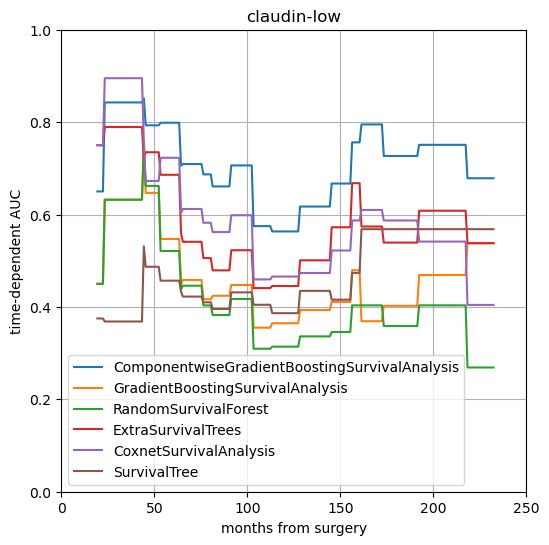

 12%|█████████▉                                                                       | 8/65 [18:53<2:14:36, 141.69s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
108
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.33745624 -1.00135096 -0.41386169 -0.2585375  -1.00889105 -1.71752265
 -1.09613207  0.38069749 -1.89755554 -1.95890443 -1.1562232  -2.53637126
 -0.82592202 -0.67072344 -1.67130313 -1.5498583  -1.04257558 -3.10039814
 -3.24621973 -2.36231342 -1.79620822 -1.9135015 ]
nan
[10.71621602  8.78778526 11.61394138 11.95647335 10.47753977 10.29506318
 10.59454747 12.52733004  9.81019201  9.76119852  9.41424624  9.14252621
 11.15956478 11.62414981  9.74215368  9.75100268 10.58886862  7.54647232
  8.82588754  7.76884679  9.42473032  7.90623914]
nan
[11.96069825 11.22155831 12.11185939 11.13473549 11.13007619 11.22657158
 11

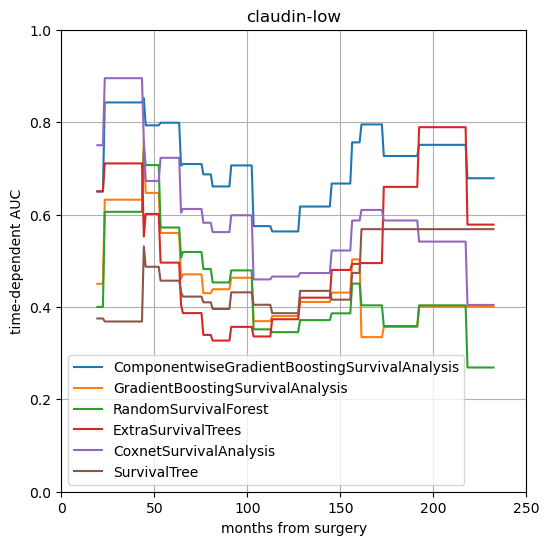

 14%|███████████▏                                                                     | 9/65 [21:13<2:11:59, 141.43s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
109
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.03628788 -0.91757581 -0.30732563 -0.38359457 -0.8610527  -1.73640223
 -0.94091286  0.36406806 -1.84877314 -1.70559336 -1.09975577 -2.45952399
 -0.63669105 -0.59205688 -1.75625785 -1.4820848  -1.12305951 -3.05872618
 -3.04996551 -2.40764805 -1.89674109 -1.86231294]
nan
[11.12606812  8.98419917 12.2194914  11.93018736 10.01461365  9.97574505
 10.78615353 12.00259138  9.28277934 10.29281362  9.85617561  9.42303012
 10.97000633 11.84104633 10.00791603  9.72304008 10.18944952  7.3372751
  8.47496562  8.26249903  9.44352503  7.58112178]
nan
[11.52539561 11.03912262 12.17528574 11.72362479 10.94943486 11.62717177
 11.

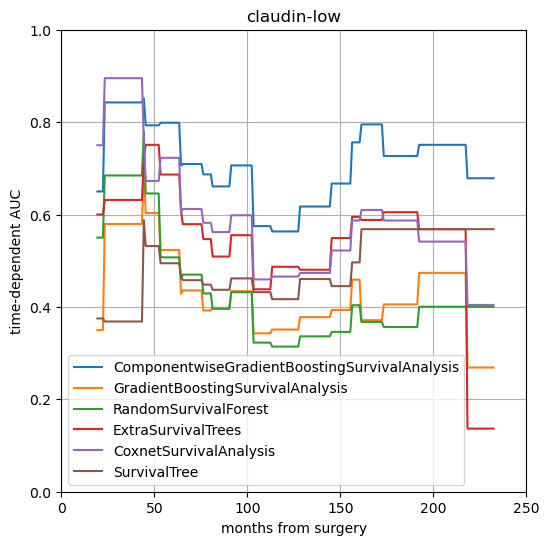

 15%|████████████▎                                                                   | 10/65 [23:33<2:09:07, 140.87s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
110
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.0961147  -1.02315457 -0.4323875  -0.29168003 -0.95437365 -1.79514684
 -0.97138626  0.22324486 -1.87101332 -1.80534913 -1.08175983 -2.53839411
 -0.7014072  -0.62132229 -1.72010177 -1.54419657 -0.94310368 -3.14852055
 -3.06566689 -2.35912122 -1.88210442 -1.77341228]
nan
[10.56724125  9.467131   12.13223754 11.53579848 10.61350117  9.9087654
 10.53645232 12.08632723  9.24006972 10.82428051  9.43176766  9.60346122
 10.69853141 11.41566297 10.23936496  9.69754244 10.58186729  7.93957078
  8.67233597  8.45356846  9.14508609  8.58406223]
nan
[11.42149344 10.86677729 12.18865119 11.47756935 11.34054608 11.45050957
 11.

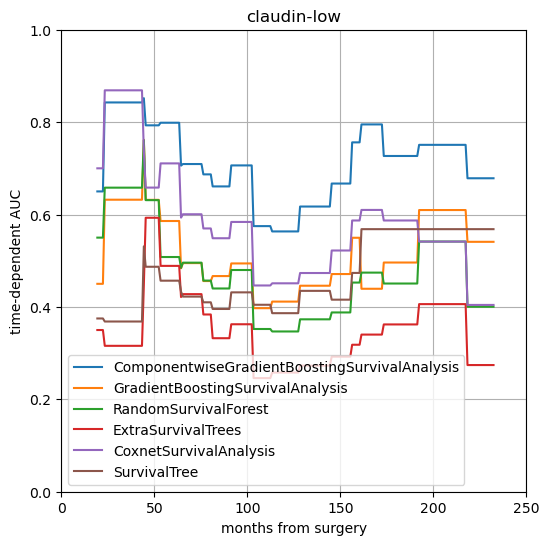

 17%|█████████████▌                                                                  | 11/65 [25:58<2:07:45, 141.95s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
111
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.26886813 -1.23775821 -0.49442174 -0.613126   -1.16937718 -2.08126509
 -1.0953117   0.20928141 -1.9410214  -1.89296411 -1.12926853 -2.78530453
 -0.73099654 -0.47983845 -1.84417737 -1.59973429 -1.10070402 -3.0507173
 -3.21184521 -2.43787786 -1.99399828 -2.18041331]
nan
[11.28622833  8.32928534 12.16306565 11.58413348  9.73231085 10.16758172
 11.20100131 11.80302687  9.7102047   9.48501914  9.02547818  8.89018198
 10.13258773 12.36137149 10.24201694  9.85051977 10.9253024   7.44390986
  8.74746537  8.2642962   9.80187408  8.16545129]
nan
[11.78630748 11.0242447  12.24664707 11.54091065 11.03253339 11.60665703
 11.

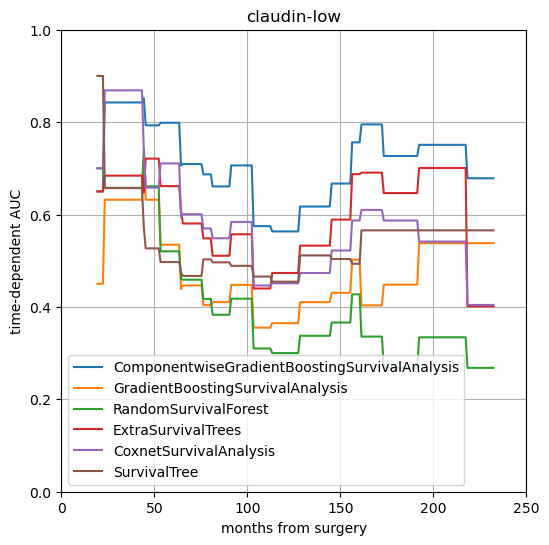

 18%|██████████████▊                                                                 | 12/65 [28:18<2:05:02, 141.57s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
112
[ 0.06871858 -0.86738998  0.48923662  0.36558002  0.15795007 -0.19220059
  0.25780772  0.39295711  0.13087509  0.06375432 -1.00719744 -0.53080321
  0.5652233   0.44562042  0.18470779  0.06413421 -0.41989771 -0.84031046
 -0.11020883 -0.99785902 -0.79606546  0.20686622]
nan
[-1.54326745 -1.12117645 -0.52067566 -0.61438314 -1.33931878 -2.07776527
 -1.07408958  0.22946783 -1.91410443 -1.93189938 -1.31141611 -2.81974279
 -0.90365336 -0.75685993 -1.93411322 -1.487889   -0.9836948  -3.22651575
 -3.23860032 -2.31204767 -2.11168298 -2.24619391]
nan
[10.53872479  9.77672293 12.55227    12.15531981 10.28693135 10.22371014
 11.08871575 12.41042725  9.62953408 10.61602133  9.44428641  9.50986797
 10.93827243 11.47329402 10.13825882  9.72680772 11.15031694  7.56104857
  8.87462912  7.79546992  9.49281622  7.92833734]
nan
[12.00717575 10.88312022 12.17568624 11.29988104 11.2142565  11.56561159
 12

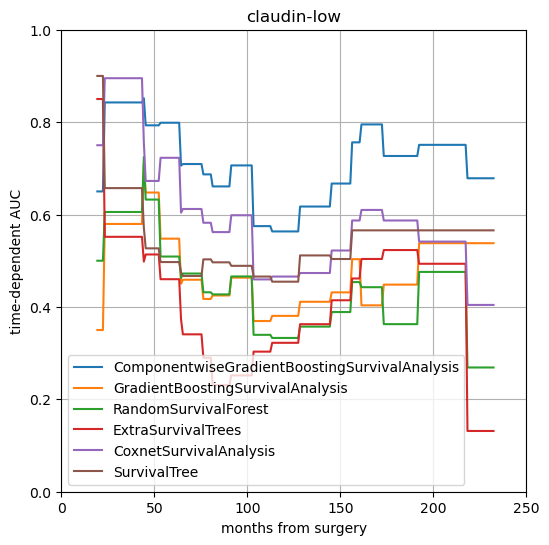

 20%|████████████████                                                                | 13/65 [30:37<2:02:03, 140.83s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
113
[ 0.07750032 -0.85977571  0.49093019  0.35030366  0.16509573 -0.19044711
  0.25972329  0.39540931  0.13957915  0.0632167  -1.00023275 -0.53499947
  0.5614221   0.44900095  0.1750051   0.05084283 -0.41811254 -0.83962093
 -0.09563022 -1.00134803 -0.80712852  0.20185184]
nan
[-1.06484481 -1.25976217 -0.53291947 -0.41597228 -1.06209943 -1.9783021
 -1.10094468  0.19586101 -2.25069078 -1.5991023  -1.09631214 -2.84862826
 -0.6096912  -0.63927644 -1.91353417 -1.46569832 -0.97483387 -3.156162
 -3.11525901 -2.40666518 -2.15894442 -2.34171021]
nan
[11.13341542  9.42146014 11.89898345 11.86183632 10.26196918  9.98429177
 11.27459646 12.77783946  9.36371901 10.21054889  9.51409753  9.11856843
 10.6584017  11.52919185  9.9189755  10.00876807 10.41196039  7.56823264
  8.71566382  8.49703117  9.38686756  8.03423233]
nan
[11.76219175 11.01292551 12.31804112 11.52777279 11.07319902 11.6958673
 12.086

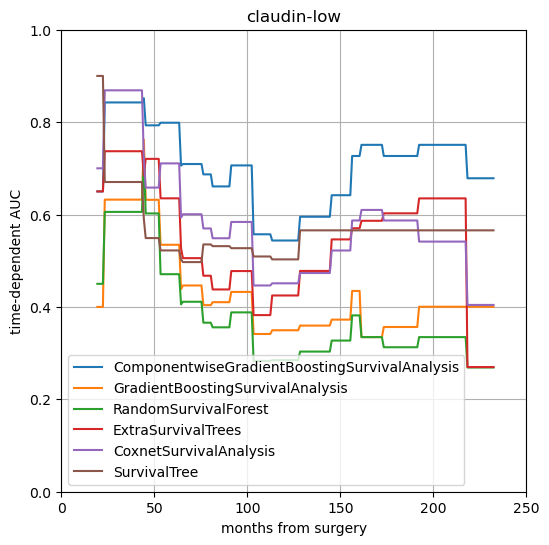

 22%|█████████████████▏                                                              | 14/65 [32:57<1:59:26, 140.53s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
114
[ 0.08839132 -0.86699389  0.47725494  0.34887585  0.1577646  -0.20324027
  0.26555853  0.40151834  0.14567734  0.06451878 -1.00151219 -0.5416625
  0.54379488  0.46322549  0.16094238  0.04776545 -0.41266459 -0.82918165
 -0.11791232 -0.98933546 -0.81747556  0.22222132]
nan
[-1.52863082 -1.29623409 -0.47775743 -0.91124906 -1.21295675 -2.00806174
 -1.02183665  0.30543712 -2.08225071 -1.7771099  -1.24225172 -2.79210739
 -0.65643235 -0.58969532 -1.70661148 -1.49579775 -1.09946814 -3.10387943
 -3.13524321 -2.52945704 -2.05184399 -2.17287507]
nan
[11.20326393  8.68691887 13.02467755 11.55548307 10.32459175  9.8689177
 10.96966819 12.63338616 10.09662598 10.21857138  9.47320816  8.7457931
 11.69152705 12.45489521 10.48959117 10.14443549 11.27337506  7.58150005
  8.61173575  8.14161989  8.7900276   8.22940164]
nan
[12.06941376 11.03960936 12.069811   11.71034187 11.39438773 11.78379316
 11.98

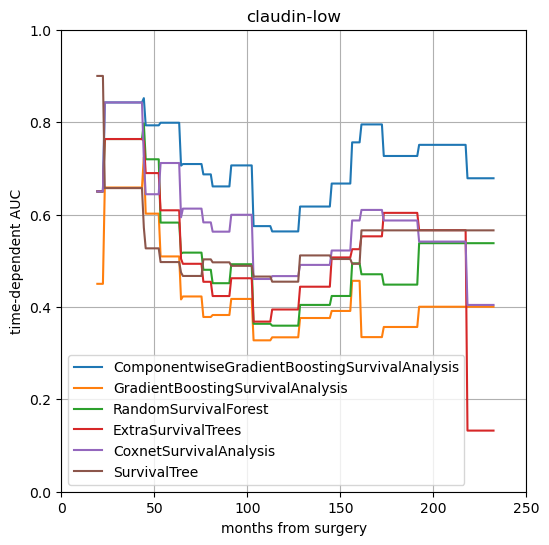

 23%|██████████████████▍                                                             | 15/65 [35:13<1:55:57, 139.15s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
115
[ 0.08839132 -0.86699389  0.47725494  0.34887585  0.1577646  -0.20324027
  0.26555853  0.40151834  0.14567734  0.06451878 -1.00151219 -0.5416625
  0.54379488  0.46322549  0.16094238  0.04776545 -0.41266459 -0.82918165
 -0.11791232 -0.98933546 -0.81747556  0.22222132]
nan
[-1.52863082 -1.29623409 -0.47775743 -0.98207389 -1.21295675 -2.00806174
 -1.02183665  0.30543712 -2.08225071 -1.7771099  -1.24225172 -2.79210739
 -0.65643235 -0.58969532 -1.70661148 -1.49579775 -1.09946814 -3.10387943
 -3.13524321 -2.52945704 -2.05184399 -2.17287507]
nan
[10.58745555  9.12799312 11.79385287 11.53712899  9.94142383 10.23804841
 11.11221253 12.18318603  9.8256616   9.99743027  9.78981234  9.17519081
 10.50962376 11.49546502  9.83816505  9.52249954 11.10520077  7.9341315
  8.61079449  8.32945675  9.75135442  7.74437762]
nan
[11.77086385 11.16196151 12.43564044 11.42136387 11.32427695 11.5073686
 11.84

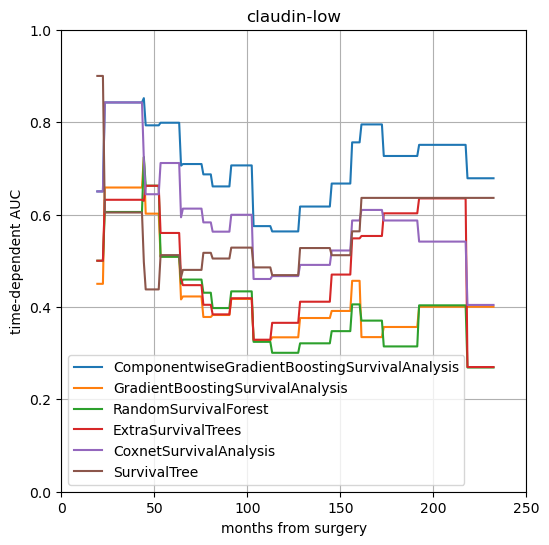

 25%|███████████████████▋                                                            | 16/65 [37:32<1:53:36, 139.11s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
116
[ 0.08839132 -0.86699389  0.47725494  0.34887585  0.1577646  -0.20324027
  0.26555853  0.40151834  0.14567734  0.06451878 -1.00151219 -0.5416625
  0.54379488  0.46322549  0.16094238  0.04776545 -0.41266459 -0.82918165
 -0.11791232 -0.98933546 -0.81747556  0.22222132]
nan
[-1.51667605 -1.33574945 -0.52988606 -0.99007667 -1.23818076 -2.18907689
 -1.04432116  0.13972915 -2.10721959 -1.74157718 -1.25907026 -2.75229903
 -0.7450498  -0.40635858 -1.81853465 -1.7548876  -0.97712534 -3.18917774
 -3.20785861 -2.36701812 -2.25446644 -2.31045816]
nan
[10.90563133  8.81147717 12.07576861 11.98004679 10.12570494  9.86752974
 11.03466985 12.31729676 10.11323853 10.90934051  9.82659598  8.78471322
 10.23888495 11.11744322  9.96980453  9.50206454 10.54638697  7.54566573
  8.57081889  8.28633142  9.31402717  8.56079446]
nan
[11.60595069 11.01030233 12.2765433  11.49419024 11.13915486 11.90511345
 11.

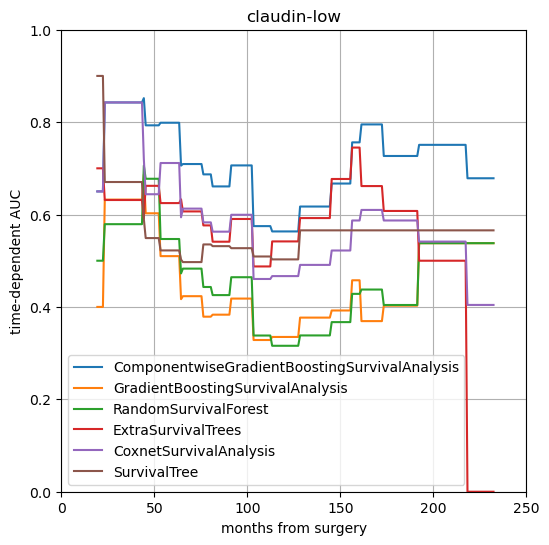

 26%|████████████████████▉                                                           | 17/65 [39:48<1:50:30, 138.13s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
117
[ 0.12770845 -0.88453472  0.50475163  0.30670297  0.18193567 -0.21418757
  0.29133548  0.3941318   0.11266365  0.11301797 -1.01646024 -0.52533501
  0.56571455  0.48670807  0.23348035  0.04813505 -0.48112648 -0.80409488
 -0.16988809 -0.95502155 -0.81994934  0.22300944]
nan
[-1.39680709 -1.30110093 -0.48279997 -1.11668937 -1.32294422 -2.0123592
 -1.04554335  0.168719   -2.12718868 -1.85390999 -1.15899491 -2.64039722
 -0.79834821 -0.82727169 -1.69747537 -1.6120521  -1.1258875  -3.22288685
 -3.1830935  -2.49778483 -2.12992802 -2.1561865 ]
nan
[10.59618304  9.14270772 12.71996662 11.63864922 10.5265831  10.68311107
 10.72267268 12.52294212  9.88888977  9.75889394  8.74982148  9.40686503
 10.42417433 12.06507651 10.77485274 10.20631713 10.21392498  7.66687756
  8.61237414  8.46260639  9.48746467  8.54034848]
nan
[11.65323846 11.51663523 12.15063313 11.52268703 11.62214743 11.43700866
 11.

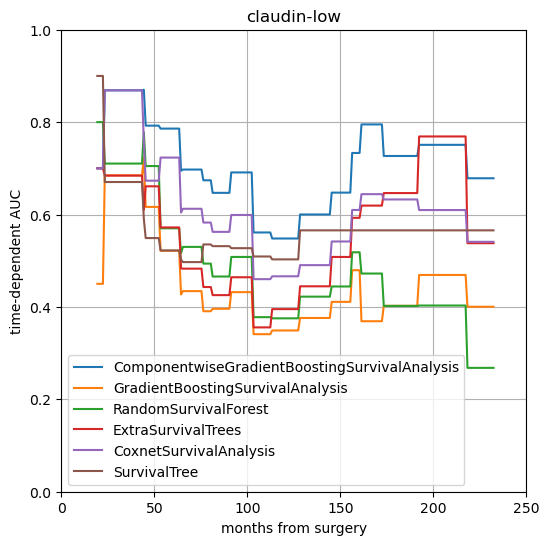

 28%|██████████████████████▏                                                         | 18/65 [42:04<1:47:41, 137.47s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
118
[ 0.09545551 -0.8893083   0.39606628  0.32073361  0.13113162 -0.33357342
  0.37915931  0.40557809  0.03991414  0.11230735 -0.96060841 -0.52357123
  0.49973975  0.42868301  0.23378257  0.09055532 -0.41884004 -0.76164978
 -0.23212781 -0.92777111 -0.79671992  0.1896205 ]
nan
[-1.81920149 -1.15345725 -1.2787811  -1.03507713 -1.60507557 -2.58046703
 -0.88329766 -0.24469067 -2.14808556 -1.94052277 -1.46688891 -2.81614699
 -1.46459776 -1.29927358 -1.9633782  -1.61184146 -1.79241019 -2.83596919
 -3.33346478 -2.81019125 -1.97341528 -2.35538281]
nan
[10.22450094  9.37354153 11.85103103 12.03299718 10.58914161  9.94964871
 11.67067615 13.30075368 10.26677208 10.27573792  9.49144217 10.00662496
 10.50433714 11.446984   10.16823872 10.72255165 11.36149181  8.13837038
  8.69816382  8.49470106  9.0600673   8.20489038]
nan
[11.7863312  11.09003495 11.90321759 11.57132695 11.0964565  11.27218746
 11

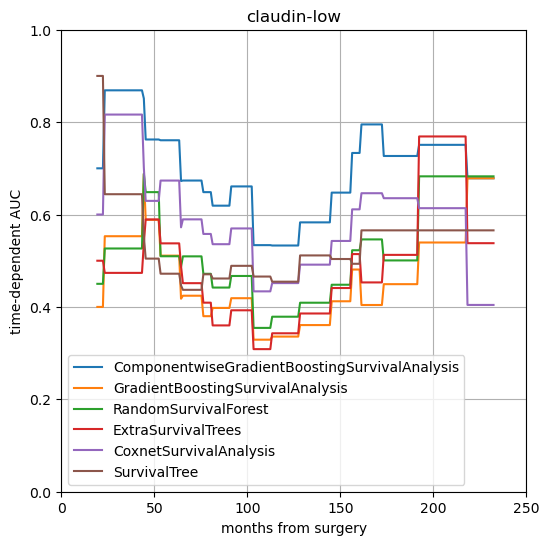

 29%|███████████████████████▍                                                        | 19/65 [44:21<1:45:16, 137.31s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
119
[ 0.09545551 -0.8893083   0.39606628  0.32073361  0.13113162 -0.33357342
  0.37915931  0.40557809  0.03991414  0.11230735 -0.96060841 -0.52357123
  0.49973975  0.42868301  0.23378257  0.09055532 -0.41884004 -0.76164978
 -0.23212781 -0.92777111 -0.79671992  0.1896205 ]
nan
[-1.8257775  -1.12516597 -1.19974883 -0.97559524 -1.57813429 -2.46072131
 -0.68446462 -0.00416331 -2.04630886 -1.69983401 -1.38062301 -2.74991058
 -1.34256153 -1.09102106 -1.85336487 -1.39776246 -1.72392548 -2.6748247
 -3.00686404 -2.72253612 -1.9523165  -2.31216367]
nan
[10.61255599  9.64057452 11.99403273 12.1097016  10.69212772 10.29083711
 11.72133689 12.76522902  9.63237258 10.30312233 10.16674541  9.41709208
  9.65963886 11.12075726  9.75122214 10.26429697 10.72474148  7.77659201
  8.60324213  8.0148039   9.32811548  8.79518133]
nan
[11.52349731 10.86658162 12.17952214 11.48918245 11.55278483 11.31235196
 12.

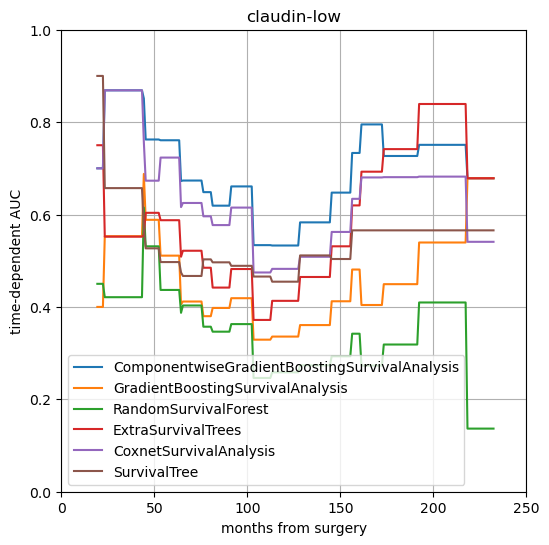

 31%|████████████████████████▌                                                       | 20/65 [46:40<1:43:21, 137.82s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
120
[ 0.18409655 -0.82034678  0.46814013  0.32702752  0.1603836  -0.39208333
  0.47031449  0.36047842  0.03787259  0.09440982 -0.83583183 -0.58783017
  0.44488891  0.38927766  0.26666958  0.03764096 -0.3595798  -0.64076927
 -0.11782356 -0.92687198 -0.74980524  0.19236532]
nan
[-1.42115285 -1.23141725 -1.17908701 -1.04879305 -1.49756891 -2.4034384
 -0.62000107 -0.15134301 -2.15154115 -1.56356593 -1.27755553 -2.82477268
 -1.38545594 -0.96280907 -1.6857226  -1.37516951 -1.80038752 -3.01180101
 -3.07960645 -2.44449331 -1.61480155 -2.20538732]
nan
[11.02800068  9.74714985 12.02385498 12.24128324 11.1648362  10.21747741
 11.73847533 12.98888604 10.13273845 10.24707179 10.24846357  9.49933852
 10.55853407 11.69867984 10.45990037 10.09352778 11.40244847  8.47040948
  8.98519322  9.0679319   9.78186364  8.54762201]
nan
[11.36371436 11.07569351 12.06063731 11.64716222 11.34967149 11.37826831
 12.

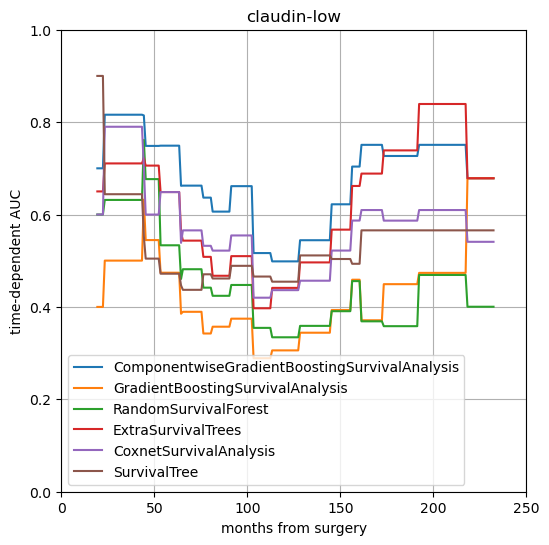

 32%|█████████████████████████▊                                                      | 21/65 [48:59<1:41:20, 138.19s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
121
[ 0.18409655 -0.82034678  0.46814013  0.32702752  0.1603836  -0.39208333
  0.47031449  0.36047842  0.03787259  0.09440982 -0.83583183 -0.58783017
  0.44488891  0.38927766  0.26666958  0.03764096 -0.3595798  -0.64076927
 -0.11782356 -0.92687198 -0.74980524  0.19236532]
nan
[-1.56750586 -1.12451134 -1.4034515  -1.19760351 -1.43392843 -2.4078541
 -0.671262   -0.23839815 -2.29878044 -1.5588339  -1.46548642 -2.75767529
 -1.42759301 -1.06415373 -1.83868545 -1.11968107 -1.7447717  -2.98972592
 -3.15929457 -2.58126579 -1.7334089  -2.1994522 ]
nan
[10.42654818  9.11991729 12.1489822  12.23891436 10.07729723  9.3078169
 11.92132535 13.57070323 10.79277779 10.45402639  9.792336    8.83843443
 10.13436885 11.49518138  9.78205507  9.23121456 11.36374353  8.01577092
  8.50227033  8.17437835  9.52034018  7.75540852]
nan
[11.7970586  11.18816329 12.34071889 11.89491645 11.2975986  11.782895
 12.124

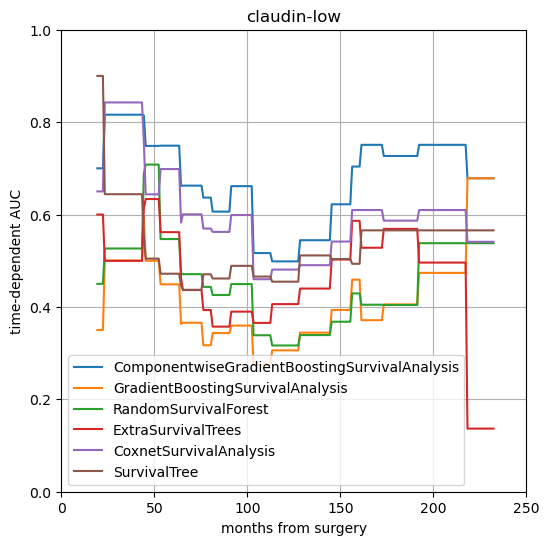

 34%|███████████████████████████                                                     | 22/65 [51:31<1:41:57, 142.28s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
122
[ 0.18409655 -0.82034678  0.46814013  0.32702752  0.1603836  -0.39208333
  0.47031449  0.36047842  0.03787259  0.09440982 -0.83583183 -0.58783017
  0.44488891  0.38927766  0.26666958  0.03764096 -0.3595798  -0.64076927
 -0.11782356 -0.92687198 -0.74980524  0.19236532]
nan
[-1.55215992 -1.36044448 -1.19357486 -1.08350803 -1.4860159  -2.47617443
 -0.67345327  0.13465527 -2.19604209 -1.42698647 -1.52692438 -2.96218844
 -1.3908851  -1.02311752 -1.91342763 -1.16444568 -1.6278313  -2.88089447
 -3.05851437 -2.65641302 -1.75629576 -2.20390143]
nan
[10.52966138  9.28052677 11.63853017 12.38300863 10.56853161  9.61082385
 10.96890147 13.18581139  9.87162538 10.23652519  9.63175877  9.49522588
  9.59923284 11.16812217 10.51908467 10.76569776 10.68201884  7.72647857
  8.41506432  8.49989444  9.63564567  8.6457914 ]
nan
[11.89247766 11.04457218 12.36376235 12.01695899 11.59847771 11.43448676
 12

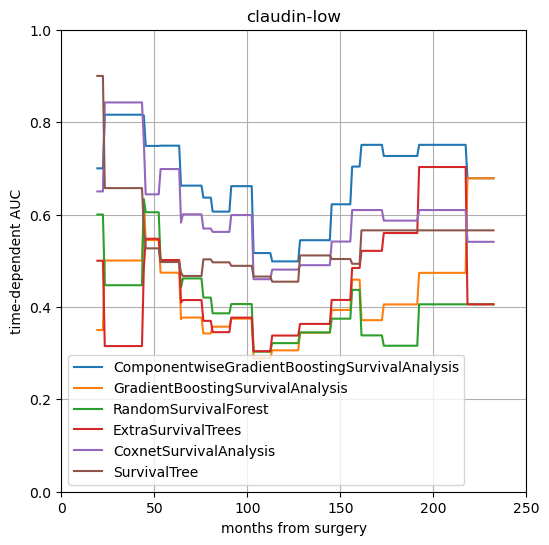

 35%|████████████████████████████▎                                                   | 23/65 [54:03<1:41:42, 145.31s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
123
[ 0.18409655 -0.82034678  0.46814013  0.32702752  0.1603836  -0.39208333
  0.47031449  0.36047842  0.03787259  0.09440982 -0.83583183 -0.58783017
  0.44488891  0.38927766  0.26666958  0.03764096 -0.3595798  -0.64076927
 -0.11782356 -0.92687198 -0.74980524  0.19236532]
nan
[-1.47474295 -1.10300869 -1.13538563 -1.27346283 -1.36812149 -2.22541584
 -0.68365933  0.10745081 -2.06754269 -1.52871503 -1.43886592 -2.70335977
 -1.28637836 -1.02917588 -1.86215238 -1.33331258 -1.44936769 -2.88216993
 -3.17856112 -2.42576601 -1.93039212 -2.30466736]
nan
[10.8017263   9.40462809 11.62984235 12.1449329  10.50928985 10.39272776
 11.52279243 13.30234035  9.80879108 10.55768355  9.69936681  9.28173077
 10.10270693 10.92827099  9.73114957 10.61524566 11.2156015   7.76454005
  8.26498312  8.34914685  9.14982737  8.25720983]
nan
[11.88382693 11.17843882 12.31020857 11.65677916 11.04627071 11.04228372
 12

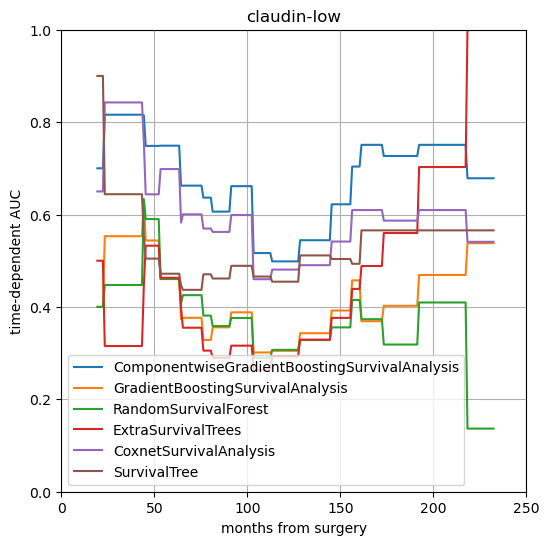

 37%|█████████████████████████████▌                                                  | 24/65 [56:37<1:41:01, 147.84s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
124
[ 0.18409655 -0.82034678  0.46814013  0.32702752  0.1603836  -0.39208333
  0.47031449  0.36047842  0.03787259  0.09440982 -0.83583183 -0.58783017
  0.44488891  0.38927766  0.26666958  0.03764096 -0.3595798  -0.64076927
 -0.11782356 -0.92687198 -0.74980524  0.19236532]
nan
[-1.69556096 -1.23082008 -1.37040614 -1.25058217 -1.40380908 -2.51755864
 -0.69018433 -0.16759075 -2.23631841 -1.5966582  -1.54922211 -2.73226807
 -1.46739424 -1.10457215 -1.89204791 -1.37282504 -1.75445696 -2.77647066
 -3.03604293 -2.67332268 -1.93402881 -2.41123208]
nan
[10.745538    9.29166477 11.68125025 11.98409684 10.91730841  9.84232909
 11.10587816 13.16288347  9.80084462 10.78308934  9.76233844  9.02329503
  9.80799038 10.51041654  9.92824423 10.44636671 10.86211588  7.98355086
  9.36260673  8.56727081  9.79403548  8.81299976]
nan
[11.9866034  11.53064832 12.0304091  11.74398072 11.28391588 11.58664478
 12

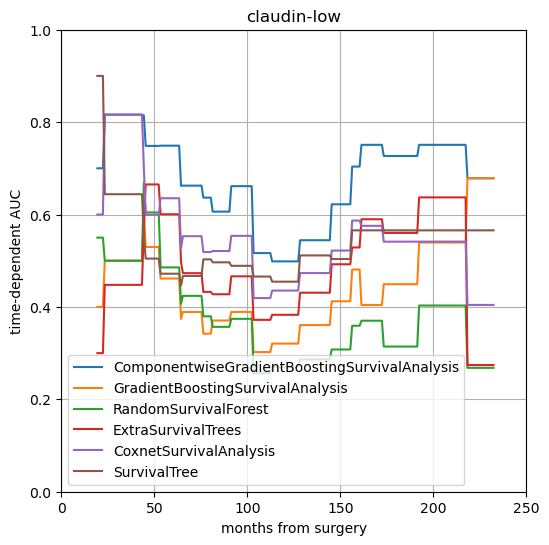

 38%|██████████████████████████████▊                                                 | 25/65 [59:09<1:39:25, 149.14s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
125
[ 0.18409655 -0.82034678  0.46814013  0.32702752  0.1603836  -0.39208333
  0.47031449  0.36047842  0.03787259  0.09440982 -0.83583183 -0.58783017
  0.44488891  0.38927766  0.26666958  0.03764096 -0.3595798  -0.64076927
 -0.11782356 -0.92687198 -0.74980524  0.19236532]
nan
[-1.53454189 -1.11998064 -1.26752663 -1.15962226 -1.63054433 -2.14138608
 -0.5396405  -0.01584361 -2.26599268 -1.62251754 -1.34666083 -2.67717889
 -1.41420055 -0.9587513  -1.87938145 -1.33881742 -1.69207239 -2.79306439
 -3.09424688 -2.72785453 -1.8721925  -2.32184272]
nan
[10.0924326   9.04124574 11.34925449 12.16177782  9.897037    8.98840983
 11.8994102  12.97254803  9.79360824 10.58577936  9.80700464  8.74885194
 10.31394945 11.86542039 10.04238052  9.84981412 11.31266961  8.30867895
  8.15583226  8.35746946  9.55671584  8.20847708]
nan
[11.46672933 11.39544456 12.14762848 11.4453934  11.33143751 11.47521981
 12

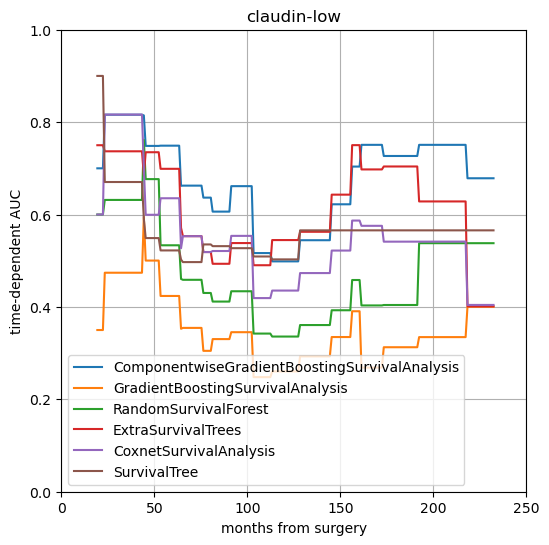

 40%|███████████████████████████████▏                                              | 26/65 [1:01:43<1:37:56, 150.68s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
126
[ 0.23905264 -0.85128439  0.45104316  0.33547169  0.24661432 -0.40440513
  0.48814937  0.43026146  0.09003932  0.10100145 -0.79164886 -0.53537696
  0.49667428  0.38226432  0.25424346  0.0064557  -0.22653257 -0.70480666
 -0.14224645 -0.85506937 -0.79379131  0.11155126]
nan
[-1.44308379 -1.01642063 -1.02982002 -1.09517942 -1.21568    -2.27553543
 -0.30167121  0.03907918 -2.32312526 -1.35980121 -1.10264622 -2.6619849
 -1.08216939 -0.65380922 -1.61927717 -1.27193968 -1.71795449 -2.92838174
 -2.91399094 -2.51402294 -1.87913967 -1.94738836]
nan
[11.08730687 10.01675401 12.18534108 12.95304556 10.80220634  9.65164483
 12.17331345 12.50616599 10.10845046 10.31921918  9.97377452  9.42100648
 10.4460514  11.89954046 10.54219925 10.90832262 10.59732832  7.76815304
  9.19103603  9.03606602  9.42403751  8.74146001]
nan
[11.99787959 11.43234191 12.35178576 11.97814034 11.4051468  11.78033511
 11.

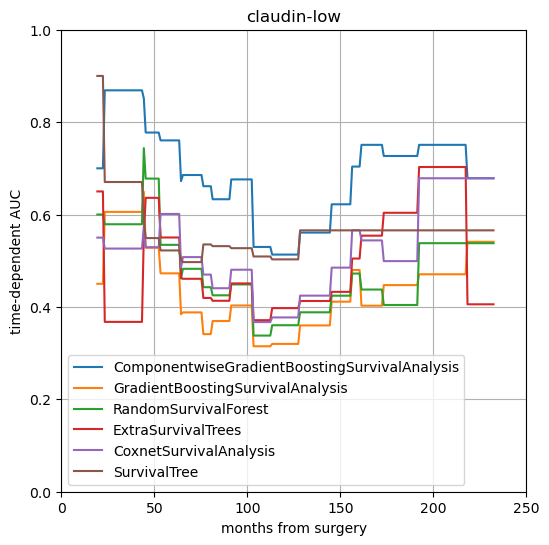

 42%|████████████████████████████████▍                                             | 27/65 [1:04:16<1:35:51, 151.37s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
127
[ 0.23905264 -0.85128439  0.45104316  0.33547169  0.24661432 -0.40440513
  0.48814937  0.43026146  0.09003932  0.10100145 -0.79164886 -0.53537696
  0.49667428  0.38226432  0.25424346  0.0064557  -0.22653257 -0.70480666
 -0.14224645 -0.85506937 -0.79379131  0.11155126]
nan
[-1.44248733 -1.08200317 -0.95764464 -1.0167072  -1.33308572 -2.23369225
 -0.42667406 -0.06262425 -2.29529201 -1.41439474 -1.11139843 -2.59366475
 -1.13406957 -0.77954098 -1.56408899 -1.3001866  -1.76904083 -2.95884782
 -2.8763564  -2.55213721 -1.88663785 -2.00637788]
nan
[11.35336887  9.87431708 12.34702752 12.1993617  10.73201655 10.16031473
 11.70411873 12.92263674 10.24910775 10.80179955 10.5046138  10.06999067
  9.88643672 11.45134852 10.16848199 10.31072979 11.45416529  7.75863685
  8.70986123  9.1316767   8.99225848  8.24639962]
nan
[11.76089579 11.39759799 12.6281173  11.66192927 11.93895249 11.62931206
 12

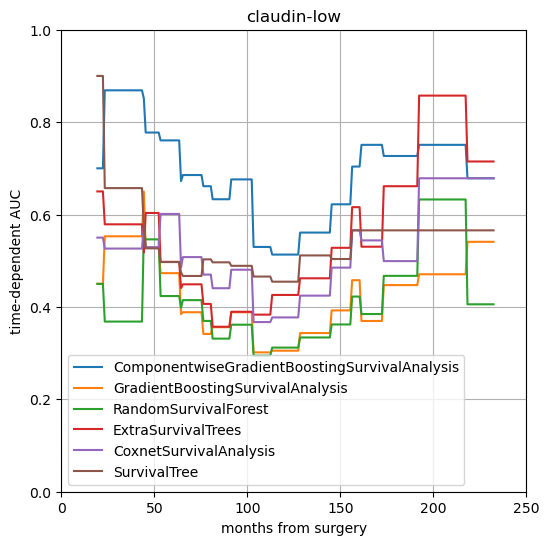

 43%|█████████████████████████████████▌                                            | 28/65 [1:06:50<1:33:41, 151.92s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
128
[ 0.23905264 -0.85128439  0.45104316  0.33547169  0.24661432 -0.40440513
  0.48814937  0.43026146  0.09003932  0.10100145 -0.79164886 -0.53537696
  0.49667428  0.38226432  0.25424346  0.0064557  -0.22653257 -0.70480666
 -0.14224645 -0.85506937 -0.79379131  0.11155126]
nan
[-1.91095334 -1.24112889 -1.32374562 -0.99781905 -1.39304637 -2.27619139
 -0.82245981  0.44276023 -2.3890491  -1.55214246 -1.34044394 -2.79076691
 -1.25003614 -1.05781348 -1.84042947 -1.37496462 -1.85512583 -2.78752241
 -2.90132374 -2.43938396 -2.02140354 -2.22713108]
nan
[10.89840734  9.23704685 11.80512306 12.29298144 10.92782866  9.69319679
 11.56130138 12.33771719  9.48581779  9.94262255  9.54533984  9.15863375
  9.88818176 12.16843098 11.13970978 10.35855083 10.78526025  8.04157212
  8.67334046  8.3162184   9.05339759  8.30667872]
nan
[11.52737653 11.55477308 12.04592214 11.93371876 11.75444771 11.33933772
 12

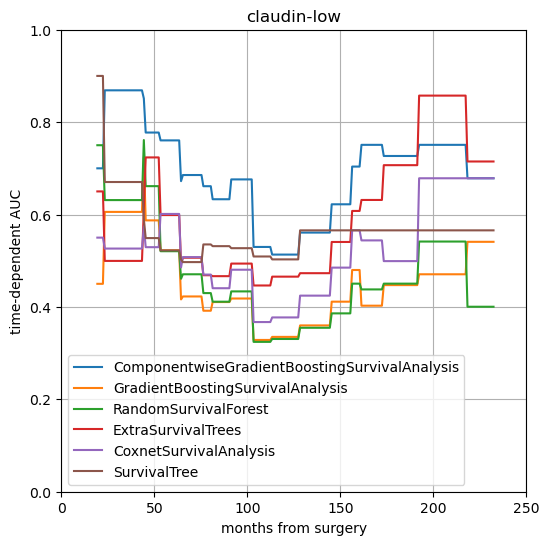

 45%|██████████████████████████████████▊                                           | 29/65 [1:09:20<1:30:56, 151.57s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
129
[ 0.23905264 -0.85128439  0.45104316  0.33547169  0.24661432 -0.40440513
  0.48814937  0.43026146  0.09003932  0.10100145 -0.79164886 -0.53537696
  0.49667428  0.38226432  0.25424346  0.0064557  -0.22653257 -0.70480666
 -0.14224645 -0.85506937 -0.79379131  0.11155126]
nan
[-1.91095334 -1.24112889 -1.32374562 -0.99781905 -1.39304637 -2.27619139
 -0.82245981  0.44276023 -2.3890491  -1.55214246 -1.34044394 -2.79076691
 -1.19802868 -1.05781348 -1.84042947 -1.37496462 -1.85512583 -2.78752241
 -2.90132374 -2.43938396 -2.02140354 -2.22713108]
nan
[10.57358287  9.68485302 11.86930685 12.05982794 11.49576788  9.95113122
 12.56221575 13.5144398  10.35751479 11.56300094 10.4832957   9.88829891
 10.39066996 12.10037115 10.12679868 10.22429172 11.93163355  7.97319512
  8.78937292  9.18690498  9.49643074  8.4797915 ]
nan
[11.7719357  11.01978113 12.33668546 11.69853376 11.46786778 11.63388415
 12

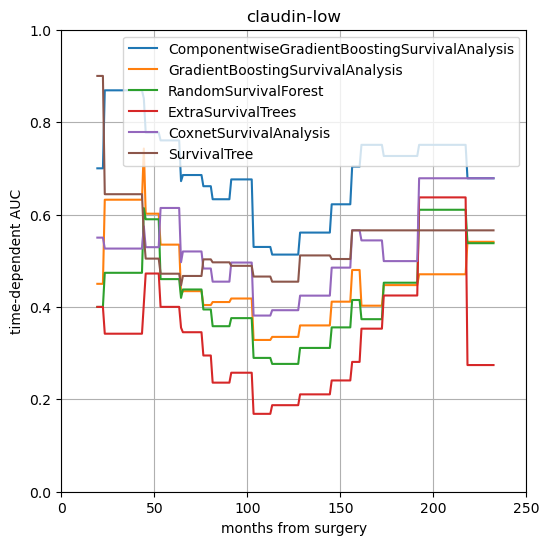

 46%|████████████████████████████████████                                          | 30/65 [1:11:55<1:28:53, 152.38s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
130
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.37816368 -1.04238949 -1.13344343 -0.96315822 -1.25377121 -2.12435129
 -0.44177255  0.26788394 -2.19596251 -1.16880189 -1.17311343 -2.67126493
 -1.12118119 -0.68996604 -1.6859761  -1.43832164 -1.76169549 -3.09173169
 -2.71189429 -2.44285283 -1.95566207 -2.11202761]
nan
[10.31256956  9.23727331 11.21742227 12.18886638 10.81375711 10.24329867
 11.82808448 13.65513301  9.77516903 10.98495442  9.96027709  9.98204626
 10.36795975 11.42638188  9.96598368 10.64796056 11.14931592  8.21192324
  9.1299758   9.33003377  9.34570026  8.71521921]
nan
[12.20671175 11.26729533 12.35423793 11.87190015 11.31730023 11.61840051
 12.

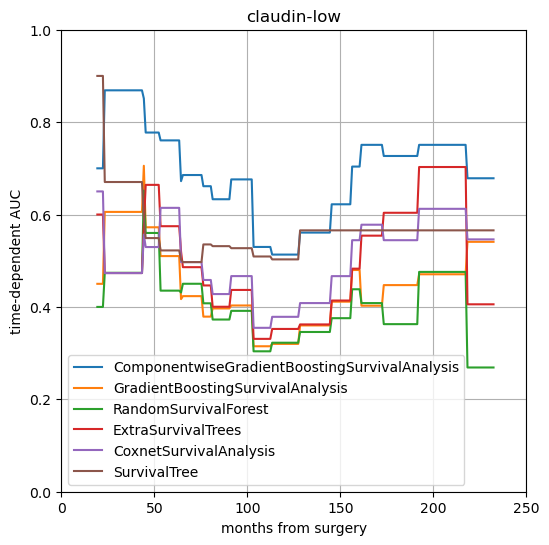

 48%|█████████████████████████████████████▏                                        | 31/65 [1:14:07<1:22:52, 146.26s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
131
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.51329642 -1.04394992 -1.1788918  -1.02261176 -1.31781081 -2.17162361
 -0.47710378  0.47562862 -2.19289556 -1.33522185 -1.20543005 -2.77806905
 -1.28844726 -0.84264745 -1.77669587 -1.38160327 -1.81421958 -2.92367834
 -2.75609853 -2.48013564 -1.88988008 -2.18555537]
nan
[10.91635652 10.04748641 11.80721182 12.92047224 11.28421011 10.26864381
 11.68166846 13.74134037  9.75325864 10.77600702 10.09446968 10.03793425
 10.34284041 11.10115527 10.18678597 10.85426225 11.73769318  8.05818615
  9.13184476  8.92263061  9.62473243  8.35214345]
nan
[11.98241024 11.35947099 12.175007   12.40596246 11.66716618 11.64599885
 12.

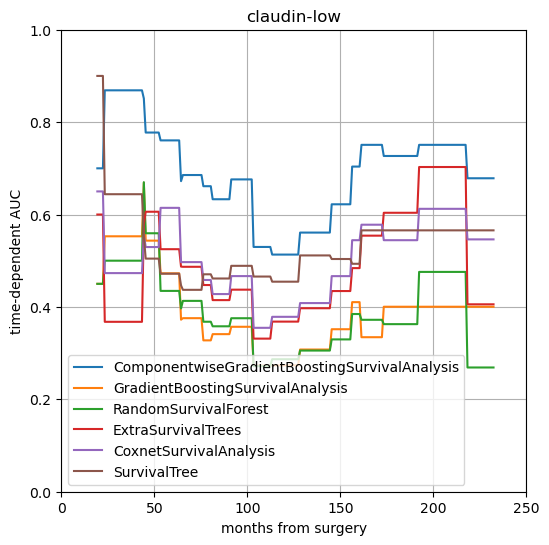

 49%|██████████████████████████████████████▍                                       | 32/65 [1:16:21<1:18:26, 142.63s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
132
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.4679137  -0.93530066 -1.03722631 -0.49433795 -1.11525803 -1.82463877
 -0.06044918  0.74694787 -2.19070483 -1.18143831 -1.01650967 -2.68810316
 -0.96888564 -0.8223704  -1.82377254 -0.98741311 -1.70845397 -3.09323275
 -2.68443461 -2.34520618 -1.30554932 -1.80274342]
nan
[10.82666472  9.57450696 11.94145096 12.48828872 10.56274193  9.85999679
 12.13350929 13.40923522  9.79867289 10.85779318 10.23850401  9.78579876
 10.92762272 11.38791907 10.45685408 10.791682   11.07338349  7.96493275
  9.10131234  9.06683822  9.54700825  8.55591958]
nan
[12.04997067 11.38643751 12.08892936 11.7899622  11.28917327 11.59216623
 12.

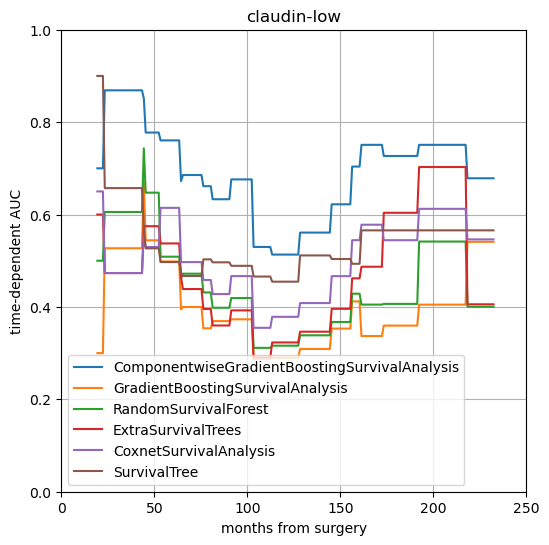

 51%|███████████████████████████████████████▌                                      | 33/65 [1:18:29<1:13:49, 138.42s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
133
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.03859989 -0.88877074 -0.83198136 -0.44699143 -1.31873949 -1.79131506
 -0.20287395  0.72800045 -1.99553145 -1.07069561 -1.28845227 -2.25300062
 -0.82131984 -0.22995611 -1.5407931  -0.83044196 -1.71816758 -2.8896861
 -2.68475236 -2.17308954 -1.1494082  -2.19313056]
nan
[10.71498127  9.70601766 11.21141974 12.72830969 10.59290229  9.83553287
 11.81085861 13.81139644  9.98355887 10.90654593  9.44695904 10.47820294
 10.63504624 11.09922366 10.22585296 10.52871929 11.80847206  7.71446221
  8.66905756  9.16729454  9.24049966  8.14543316]
nan
[12.12623466 11.35025013 12.09307812 11.71063004 11.44830686 11.32691591
 12.4

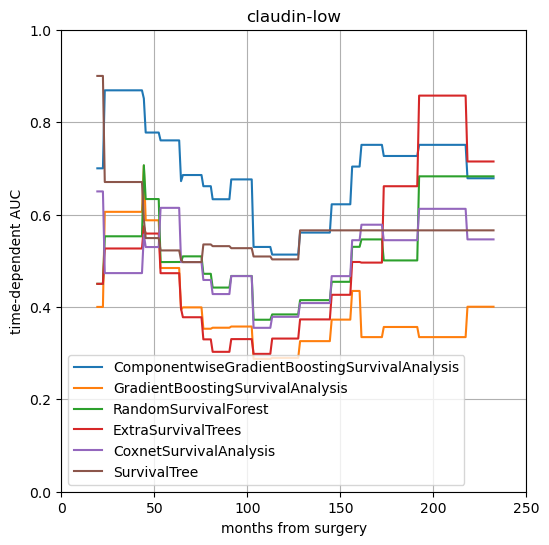

 52%|████████████████████████████████████████▊                                     | 34/65 [1:20:30<1:08:49, 133.21s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
134
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.05043103 -0.88877074 -0.83198136 -0.44699143 -1.31873949 -1.79131506
 -0.20287395  0.72800045 -1.99553145 -1.07069561 -1.28845227 -2.25300062
 -0.82131984 -0.23292408 -1.55262424 -0.83044196 -1.71816758 -2.8896861
 -2.68475236 -2.17308954 -1.13665068 -2.19313056]
nan
[10.89529909  9.98541122 11.83324813 12.31972116 10.77860188 10.11263456
 11.50763253 13.71074562 10.23063322 10.8159601   9.78112628 10.25431569
 10.16287341 12.10414444 10.79469761 10.84637107 11.22144511  8.00974244
  8.94476354  9.22322619  9.14817182  8.67335046]
nan
[11.96944472 11.2846248  12.06035955 11.85055298 11.69611692 11.38460253
 12.2

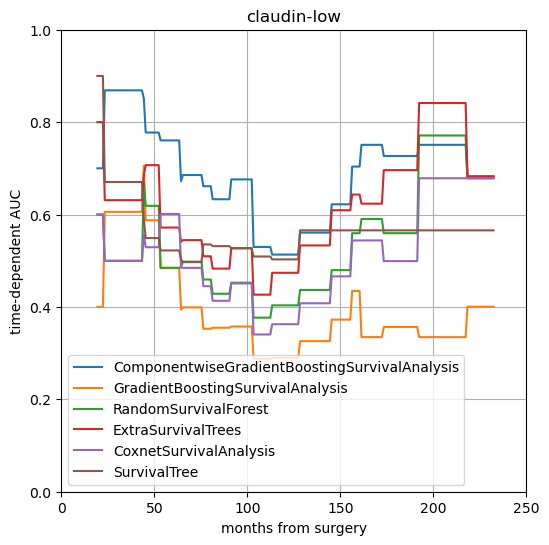

 54%|██████████████████████████████████████████                                    | 35/65 [1:22:34<1:05:06, 130.22s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
135
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.18691909 -0.91436598 -0.93550828 -0.43247112 -1.36869623 -1.77552089
 -0.25467771  0.74121016 -2.03398771 -1.10974465 -1.31705045 -2.32473558
 -0.9622724  -0.39858672 -1.68452885 -0.79597081 -1.67419228 -2.89614279
 -2.73672203 -2.19059367 -1.09776779 -2.18347792]
nan
[10.92031685 10.27891679 12.00508457 12.69717879 10.99803679 10.24803923
 12.29681545 13.71516016 10.34763614 11.05264667 10.18216714 10.42313113
 10.80715294 11.91365794 10.34061384 11.09596204 11.25741803  8.92051685
  9.25007575  9.01647995  9.69885392  8.87884944]
nan
[12.17080579 11.62893887 12.36355688 12.03696953 11.43314173 11.94758673
 12.

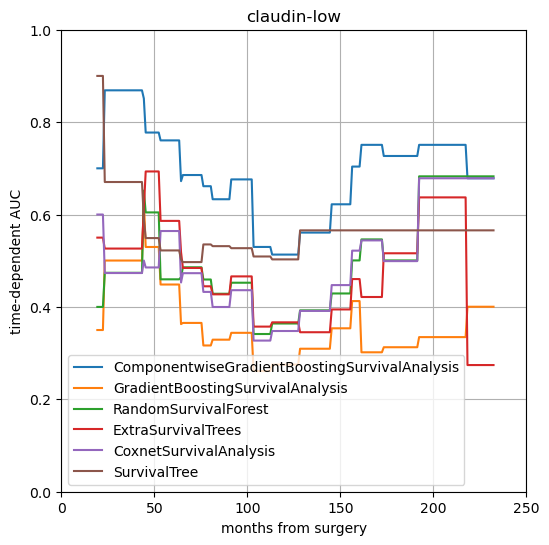

 55%|███████████████████████████████████████████▏                                  | 36/65 [1:25:14<1:07:19, 139.31s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
136
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.20197896 -0.96476344 -0.78877144 -0.30508661 -1.39158801 -1.86468491
  0.22419785  1.16865188 -2.17143609 -1.02353023 -1.26620865 -2.3470748
 -0.9853289  -0.31914915 -1.37871929 -0.71181821 -1.56784039 -3.06684685
 -2.61100747 -2.26360642 -1.0506246  -1.96997521]
nan
[11.04662305  9.98010555 12.18986551 12.32735025 10.88464106  9.82169121
 12.25092028 14.12512601  9.95870021 10.92938254 10.13180888  9.94004406
 10.74226262 11.66696858 10.40623405 10.78446151 11.01021976  8.07029037
  9.03209235  9.0022605  10.30941586  8.78726628]
nan
[11.96193474 11.47095414 12.05529913 11.84234986 11.43666769 11.49503354
 12.4

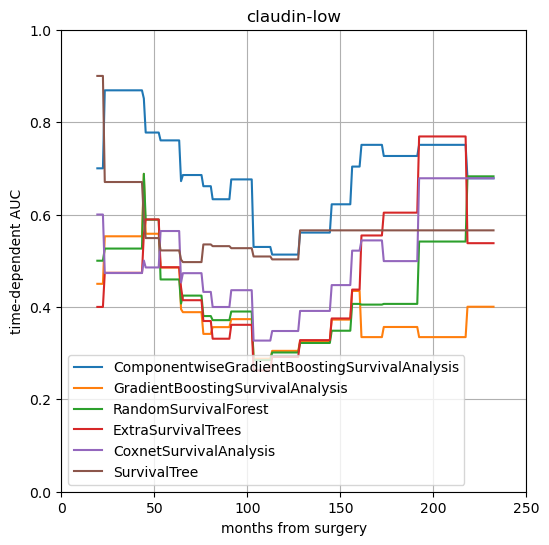

 57%|████████████████████████████████████████████▍                                 | 37/65 [1:28:02<1:09:02, 147.94s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
137
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.28172052 -0.92710769 -0.84358412 -0.31563793 -1.36350428 -1.76925541
 -0.22816408  0.91901383 -2.00498663 -1.27344715 -1.33704342 -2.3145638
 -0.88451697 -0.42561008 -1.35814675 -0.96697908 -1.37471723 -2.96800924
 -2.72311867 -2.25066446 -1.15090172 -2.19481738]
nan
[11.22794448 10.74037843 11.73761476 12.15020545 11.66643883 10.11827201
 12.48171659 13.29670871 10.4641041  11.73214592 10.50342706 10.96064059
 11.31106071 12.06870849 10.78821753 11.17674993 11.78893755  8.55311172
 10.13148083  9.38752138  9.92577349  9.17212916]
nan
[12.28496464 11.36429263 12.14970179 11.95730638 11.61047239 11.56502164
 12.7

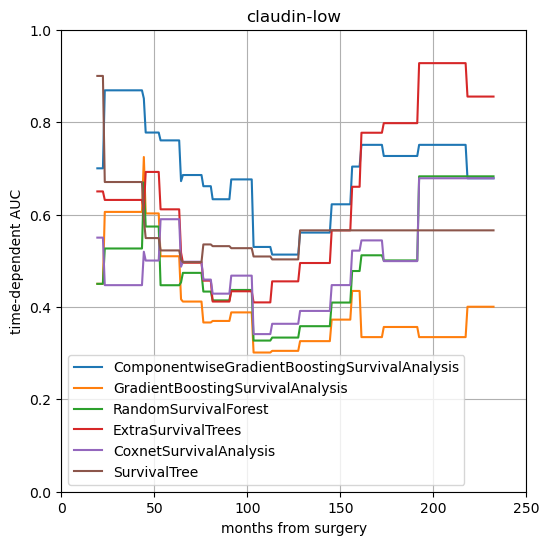

 58%|█████████████████████████████████████████████▌                                | 38/65 [1:30:47<1:08:51, 153.03s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
138
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.36664375 -0.83232579 -0.97769568 -0.22301235 -1.43081704 -1.82174247
  0.0266194   1.06380013 -2.23297419 -1.52407816 -1.35337665 -2.40818176
 -0.92365072 -0.44119405 -1.85279563 -0.90788192 -1.27898859 -2.69467239
 -2.77198361 -2.40438359 -1.3273049  -2.21760497]
nan
[10.78814055  9.76884216 10.75869142 12.45901552 11.03599392 10.22173176
 11.57381506 13.48140502 10.7141254  10.82028984 10.28425789 10.56813697
 10.58729968 11.66386195 10.72733699  9.97410688 11.40728414  8.5148231
  9.90830556  8.95529085  9.63086676  8.71729254]
nan
[11.87373764 11.60412906 11.99313932 11.81003061 11.30513291 11.73755544
 12.6

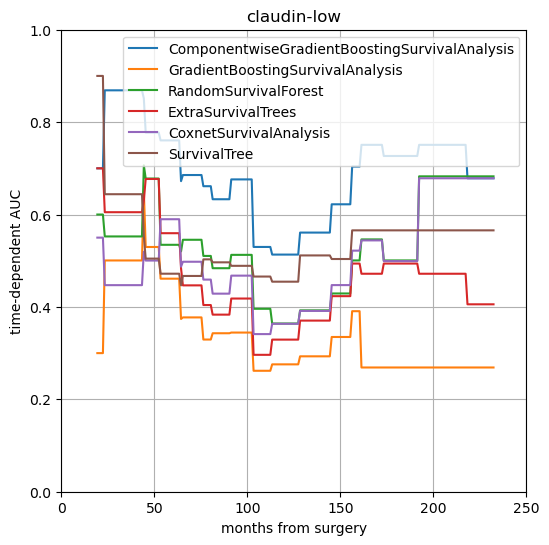

 60%|██████████████████████████████████████████████▊                               | 39/65 [1:33:33<1:07:58, 156.87s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
139
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.37988007 -0.83232579 -0.97769568 -0.22301235 -1.43081704 -1.82174247
  0.0266194   1.06380013 -2.23297419 -1.52407816 -1.35337665 -2.40818176
 -0.92365072 -0.45762758 -1.86603195 -0.90788192 -1.27898859 -2.69467239
 -2.77198361 -2.40438359 -1.31406859 -2.21760497]
nan
[10.78480989  9.83105753 11.69549301 12.96994716 10.68199653  9.86573811
 11.51527169 13.47131269 10.40987074 11.37331637  9.93591537 10.61823015
 11.11817158 11.29447374 10.10033897 10.82016766 11.10749715  8.55876144
  9.50746326  8.46223741 10.07558806  7.71114846]
nan
[12.12295473 11.78325639 12.26644544 11.86479164 11.55793421 11.70658065
 12.

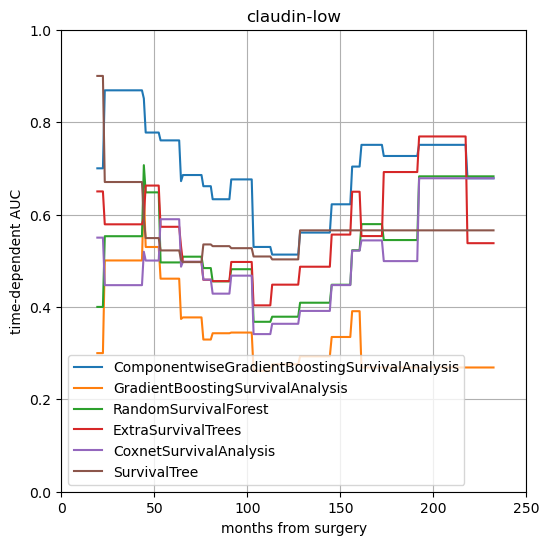

 62%|████████████████████████████████████████████████                              | 40/65 [1:36:20<1:06:35, 159.82s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
140
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.37988007 -0.83232579 -0.97769568 -0.22301235 -1.43081704 -1.82174247
  0.0266194   1.06380013 -2.23297419 -1.52407816 -1.35337665 -2.40818176
 -0.92365072 -0.46152037 -1.86603195 -0.90788192 -1.27898859 -2.69467239
 -2.77198361 -2.40438359 -1.30055222 -2.21760497]
nan
[10.69811098  9.82576878 11.60360644 11.95954226 10.87326786 10.2244785
 11.91279018 13.83228042  9.80807997 10.40842813  9.93234512 10.8294396
  9.97773828 12.08577304 10.70863378 10.37574653 11.62493447  8.09243288
  8.74948505  8.72529302  9.69770879  8.69172785]
nan
[12.19447721 11.6393189  12.53983636 12.1271701  11.16283437 11.6402582
 12.482

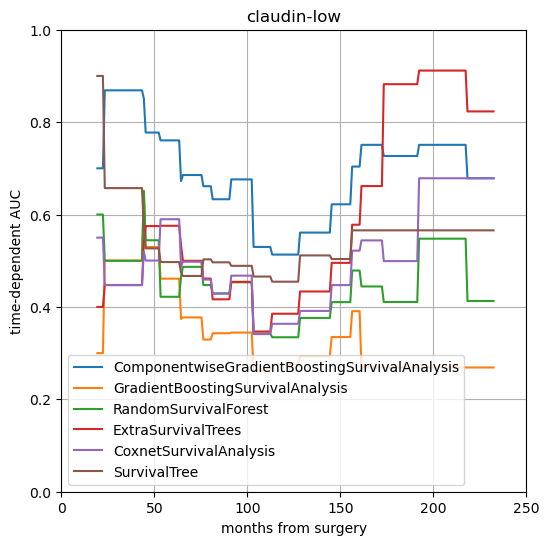

 63%|█████████████████████████████████████████████████▏                            | 41/65 [1:39:08<1:04:58, 162.43s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
141
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.28942694 -0.88242186 -0.76745151 -0.33339057 -1.37464075 -1.81438069
  0.07677198  1.19036764 -2.06189172 -1.41586302 -1.23070629 -2.52111188
 -0.95814359 -0.32013279 -1.59771018 -0.93582727 -1.42336057 -2.9511968
 -2.71650983 -2.28095066 -1.23766955 -2.1778259 ]
nan
[10.23820486  9.8165664  12.0632764  12.58840457 11.04312595 10.4208405
 12.31869862 13.28712731 10.11803532 10.67675104  9.97273342 10.14226506
 11.18065911 12.48656723 10.3399409  10.97188432 11.52803655  8.37773548
  9.58461656  9.10514781  8.98046088  9.41021612]
nan
[11.80668189 11.62349625 12.20610754 11.83307957 11.76303578 12.0914686
 12.532

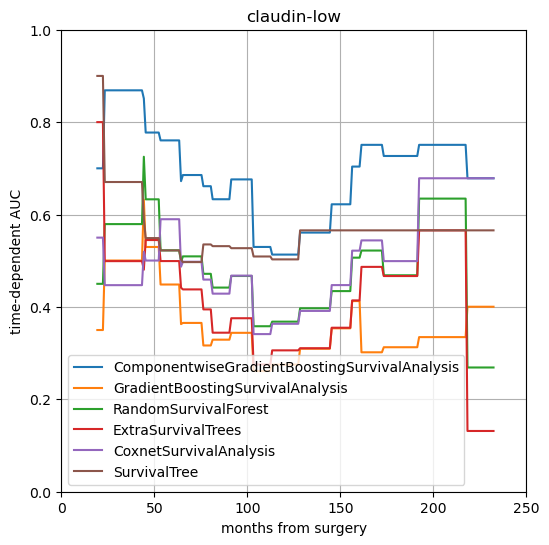

 65%|██████████████████████████████████████████████████▍                           | 42/65 [1:41:52<1:02:23, 162.75s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
142
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.303129   -0.88242186 -0.76745151 -0.33339057 -1.37464075 -1.81438069
  0.07677198  1.19036764 -2.06189172 -1.41586302 -1.23070629 -2.52111188
 -0.95814359 -0.32013279 -1.61141225 -0.93582727 -1.42336057 -2.9511968
 -2.71650983 -2.28095066 -1.22396749 -2.1778259 ]
nan
[11.14083644  9.54513361 11.41396375 12.60344929 10.51738208  9.74448042
 11.94206399 13.37187883 10.26823211 10.45290633 10.07612287  9.9381349
 10.22990984 11.57244843 10.08928873 10.02684188 11.44732395  7.95183744
  9.77162734  9.56593923  9.85075342  8.56378809]
nan
[11.93969089 11.54691056 12.44847657 11.82818834 11.71365616 11.8810611
 12.516

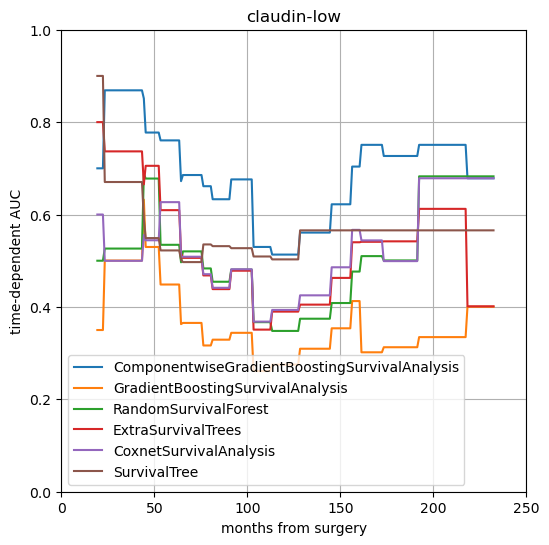

 66%|████████████████████████████████████████████████████▉                           | 43/65 [1:44:33<59:34, 162.47s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
143
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.33147544 -0.86097947 -0.91058515 -0.3715518  -1.34538486 -1.93243048
 -0.01693026  1.04718736 -2.11072949 -1.40920229 -1.30795018 -2.5957406
 -1.08998606 -0.53981292 -1.73602112 -0.90660737 -1.27519934 -2.9853478
 -2.78629904 -2.29730524 -1.22614115 -2.23127035]
nan
[11.61570302  9.8068243  12.04096981 12.44165005 10.8900311  10.43091283
 11.89213884 14.58030788 10.52594812 11.71572617 10.68514465 10.91501987
 11.0829803  11.84596914 10.0940007  10.39769164 11.67439528  8.10576505
 10.11855177  9.08145057  9.56040162  8.87724635]
nan
[11.98913048 11.50393375 12.32183739 11.85248639 11.56336234 11.70297334
 12.46

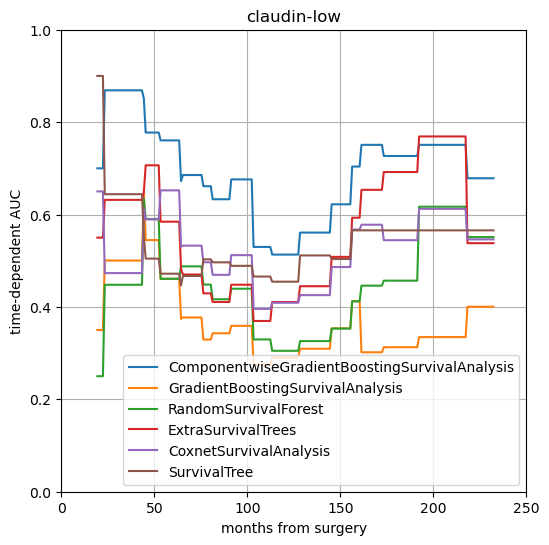

 68%|██████████████████████████████████████████████████████▏                         | 44/65 [1:47:14<56:41, 161.96s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
144
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.33977914 -0.74492488 -0.8423905  -0.24673352 -1.48836989 -1.67387465
  0.09188715  1.2619265  -2.04278095 -1.44542    -1.36194118 -2.48721217
 -1.04655095 -0.38219319 -1.55480713 -0.79358909 -1.38620442 -2.98182193
 -2.73752004 -2.10472469 -1.08242228 -2.14811102]
nan
[11.07528618  9.48837855 11.60019732 12.66146035 11.3192602   9.73083435
 11.41426203 13.75617391 10.42579408 10.96971899 10.44977257 10.48348289
 11.20865064 11.71047762 10.06435297 10.45290554 11.08657452  8.22710235
  9.62303819  8.44137344  9.59680606  8.46372711]
nan
[12.26633677 11.67256102 12.30204443 11.97341472 11.69924346 11.61701633
 12.

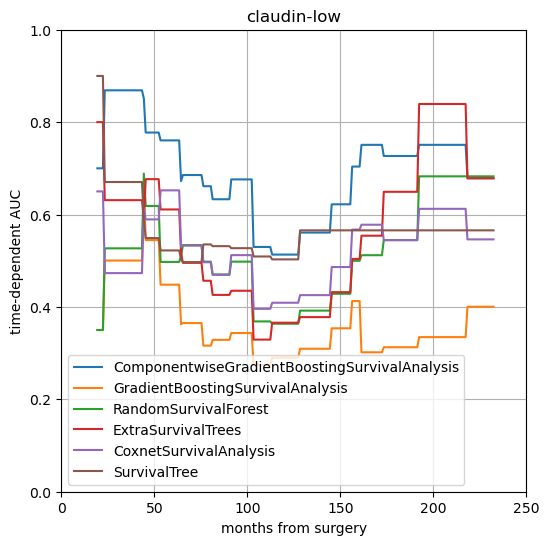

 69%|███████████████████████████████████████████████████████▍                        | 45/65 [1:50:10<55:20, 166.01s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
145
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.33977914 -0.74492488 -0.8423905  -0.24673352 -1.48836989 -1.67387465
  0.09188715  1.2619265  -2.04278095 -1.44542    -1.36194118 -2.48721217
 -1.04655095 -0.37082235 -1.55480713 -0.79358909 -1.38620442 -2.98182193
 -2.73752004 -2.10472469 -1.08242228 -2.14811102]
nan
[11.2767309   9.41757973 11.55994207 12.55263375 10.60293775 10.42422766
 12.02850152 13.68372426 10.65076113 10.74995504 10.49099407 10.38473497
 10.25781811 11.24876429 10.77708007 11.03390007 11.70421535  7.59636127
  9.63793729  8.91204373 10.19631373  8.55512942]
nan
[12.01755854 11.67388848 12.09041897 12.1570559  11.57272239 11.57912625
 12.

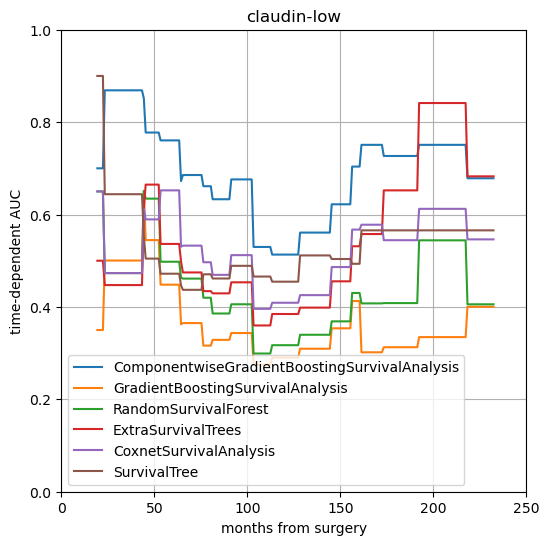

 71%|████████████████████████████████████████████████████████▌                       | 46/65 [1:53:04<53:19, 168.39s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
146
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.25486187 -0.79036526 -0.65893187 -0.16217864 -1.34416462 -1.91544132
  0.13513724  1.40396827 -2.10481306 -1.37258139 -1.12748124 -2.38708746
 -0.96420999 -0.44482216 -1.48095127 -0.8246807  -1.23894385 -2.96425165
 -2.75135999 -2.17582731 -1.03693144 -2.16026236]
nan
[11.00224692  9.88201753 11.44810452 12.26152373 10.79914407 10.0198562
 11.62567051 13.10739723 10.41725752 10.620862    9.75051241 10.17801915
 10.92172724 11.59148885 10.24716468 10.64468728 11.51963279  8.64172528
  9.63931224  9.45999669  9.79506329  8.67205401]
nan
[11.77007987 11.56105708 12.4595611  12.01900985 11.63877061 11.87124569
 12.7

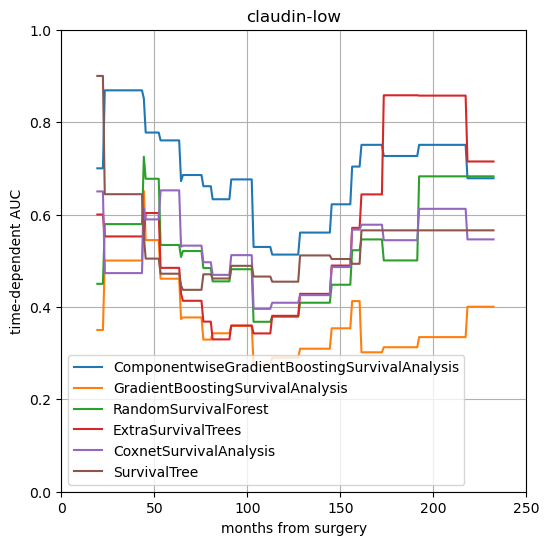

 72%|█████████████████████████████████████████████████████████▊                      | 47/65 [1:55:57<50:56, 169.79s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
147
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.32806453 -0.74907337 -0.67143172 -0.24777113 -1.46797401 -1.99974365
  0.07299878  1.28531045 -2.1851822  -1.55163097 -1.34484903 -2.31291255
 -0.85470001 -0.43241478 -1.42340347 -0.99542988 -1.10180026 -2.98342397
 -2.79654421 -2.20663265 -1.01797791 -2.20792032]
nan
[11.89267811 10.20241592 12.10985615 12.18392739 10.05571557 10.12585354
 12.59562056 14.04566996 10.20600215 11.64048385 10.94340516  9.99894553
 10.70433621 11.35693461  9.88774113 11.18643039 11.13734589  8.72058311
  9.7421668   9.63928154  9.47199363  8.41363437]
nan
[12.13109409 11.46012868 12.26957024 12.10775396 11.64665047 11.87799699
 12.

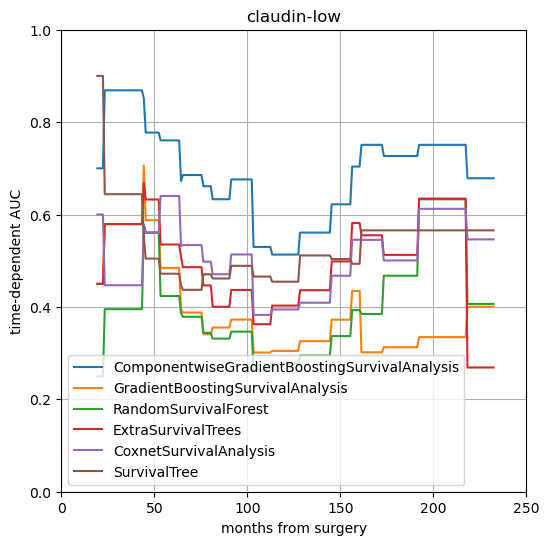

 74%|███████████████████████████████████████████████████████████                     | 48/65 [1:58:51<48:28, 171.06s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
148
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.42683162 -0.90451772 -0.77523677 -0.36543559 -1.50136585 -1.99956341
  0.14102799  0.95367422 -2.32320578 -1.54715483 -1.3506837  -2.47701171
 -0.90807662 -0.50422741 -1.76495505 -1.02003978 -0.9125759  -2.66015737
 -2.93424504 -2.12144147 -1.36128565 -2.3265241 ]
nan
[10.81747434  9.926915   11.5312038  12.82251486 10.92215705 10.07009034
 12.5030518  13.57879649 10.49477154 10.61259349 10.11200541 10.02364347
 10.63792911 11.6915311  10.47579119 11.18858482 11.2082715   8.35491986
  9.89811235  9.15853332  9.68505547  8.68469451]
nan
[12.24788217 11.6258416  12.71413601 12.10536785 11.63754912 12.12041819
 12.

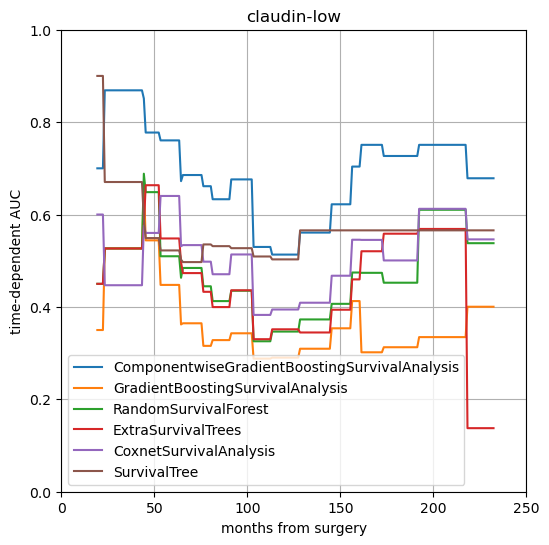

 75%|████████████████████████████████████████████████████████████▎                   | 49/65 [2:01:46<45:56, 172.28s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
149
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.36020817 -0.81883728 -0.7683185  -0.49543608 -1.52929151 -1.91944929
 -0.18025918  1.01862137 -2.08756179 -1.37483753 -1.30768181 -2.47440451
 -0.84164073 -0.5683648  -1.67039435 -0.95125371 -1.28161755 -2.86689617
 -2.74175904 -2.07697186 -1.1971785  -2.25181481]
nan
[11.30113812  9.15363198 11.02383295 12.6074907  10.69159274 10.20291225
 11.97665426 12.97836207 10.17935011 10.73954815 10.0207104  10.34956415
 10.84843506 11.63812361  9.9734628  10.63150082 11.42669065  8.02030031
  9.18131513  9.03703541  9.53151837  8.72660402]
nan
[11.78073308 11.62079468 12.37703788 12.24410827 11.62203363 11.8268017
 12.3

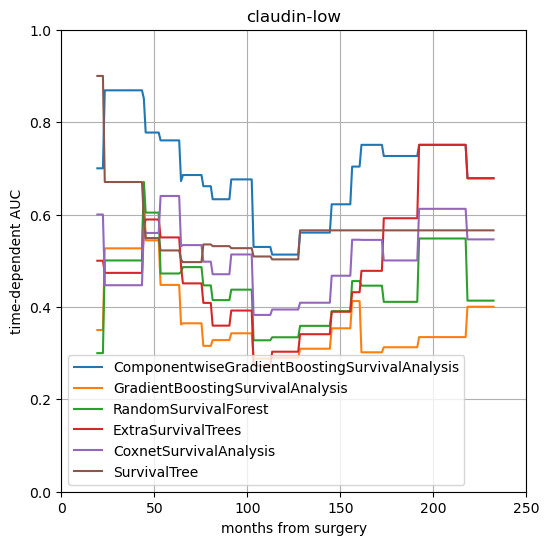

 77%|█████████████████████████████████████████████████████████████▌                  | 50/65 [2:04:40<43:12, 172.84s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
150
[ 0.24283503 -0.83710101  0.43106907  0.33406223  0.24092311 -0.40611474
  0.48842816  0.43048405  0.0806898   0.09935606 -0.77971559 -0.5196318
  0.49931262  0.36945721  0.24816078 -0.00244994 -0.23318943 -0.70787193
 -0.12481408 -0.86266626 -0.80011392  0.11219118]
nan
[-1.36096368 -0.84325211 -0.76299202 -0.3716901  -1.55306983 -1.86538289
 -0.28994908  1.0754218  -1.99811608 -1.42120545 -1.32859066 -2.33608856
 -0.77799198 -0.44764597 -1.61515413 -1.00368961 -1.29533607 -2.84807138
 -2.73518775 -2.07609387 -1.17394803 -2.26174198]
nan
[11.62462146  9.70717801 11.34520663 12.26584471 11.0011778   9.83884701
 12.09212466 14.01229089 10.43130905 10.97798453 10.32597378 10.39199068
 10.34576201 12.22723722 10.72256203 11.52496454 10.96370277  8.86065832
  9.38469842  9.261758    9.71387303  8.86058064]
nan
[12.29353004 11.83216295 12.13261593 12.38076574 11.49871593 11.88347753
 12.

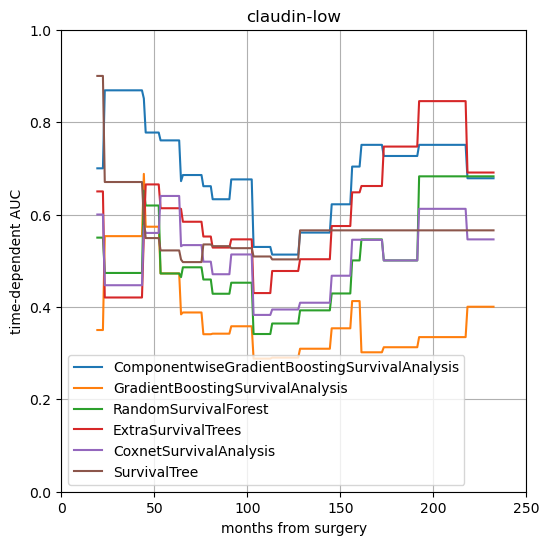

 78%|██████████████████████████████████████████████████████████████▊                 | 51/65 [2:07:37<40:39, 174.23s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
151
[ 2.42014226e-01 -8.37441834e-01  4.30188923e-01  3.36176723e-01
  2.39855056e-01 -4.06752945e-01  4.86620658e-01  4.32214049e-01
  8.06193612e-02  9.94382404e-02 -7.81636418e-01 -5.17546130e-01
  4.97772948e-01  3.69153437e-01  2.51330267e-01 -3.71390244e-04
 -2.33271960e-01 -7.06370545e-01 -1.23531204e-01 -8.62285597e-01
 -8.01874916e-01  1.11495393e-01]
nan
[-1.34659294 -0.69973677 -0.89686287 -0.34788987 -1.50946792 -1.93280144
 -0.24327033  1.09783139 -1.87441554 -1.36872123 -1.21590663 -2.19959929
 -0.91388322 -0.65290302 -1.64706418 -0.97745016 -1.28296376 -2.8237602
 -2.84649496 -1.90055791 -1.11055039 -2.27301918]
nan
[11.01569279  9.71343686 11.65071157 12.78733584 11.19889132  9.8017678
 11.74151104 14.09258392 10.54105944 11.41354373  9.92151109 10.04437223
 10.57012073 11.7438621  10.05470737 10.9921478  11.73599908  8.43451038
  9.37315794  9.29473543  9.30433985  8.56

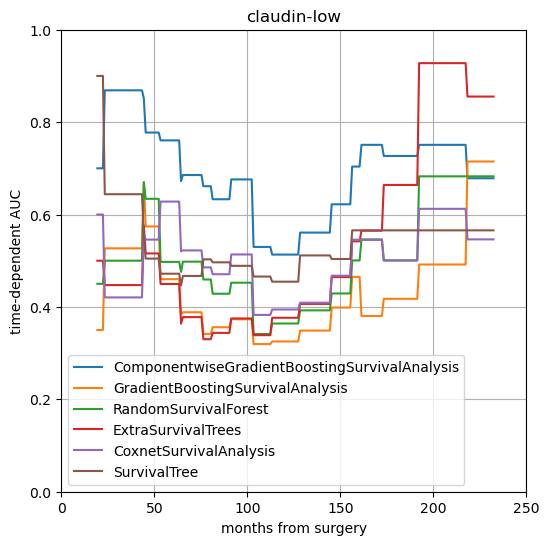

 80%|████████████████████████████████████████████████████████████████                | 52/65 [2:10:38<38:08, 176.02s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
152
[ 0.21885289 -0.83105454  0.42513525  0.34174368  0.23085985 -0.41027423
  0.48803255  0.41685696  0.07142848  0.09833764 -0.78052041 -0.50190555
  0.47709097  0.34741843  0.26084803  0.00334419 -0.23569893 -0.68715559
 -0.12843327 -0.87865023 -0.78014357  0.10223508]
nan
[-1.31301706 -0.6865413  -0.74033681 -0.33542916 -1.49258588 -1.87509181
 -0.1659461   1.068077   -1.86833227 -1.37065793 -1.23600262 -2.12658619
 -0.85826925 -0.72702202 -1.56231673 -0.98020881 -1.17482331 -2.85581846
 -2.7042429  -1.99888836 -1.1404363  -2.24006478]
nan
[11.34456554  9.71027758 11.56685482 12.50842828 10.94820759 10.60505221
 12.28279918 13.54529688 10.30370946 11.03665437  9.80315424 10.89528957
 11.43048423 12.10103657 10.43891038 10.91515202 11.07139974  8.82210548
  9.83648648  8.53517483 10.25435122  9.25103416]
nan
[12.09649913 11.56855963 12.26081587 12.45427966 11.48852621 11.59225945
 12

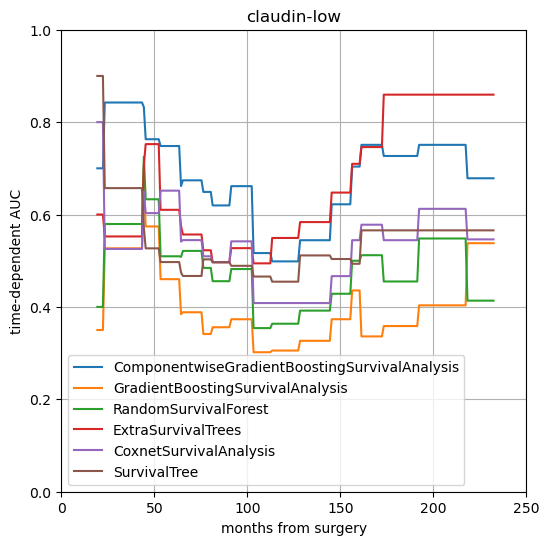

 82%|█████████████████████████████████████████████████████████████████▏              | 53/65 [2:13:37<35:24, 177.08s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
153
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.4824482  -0.7672176  -0.87094261 -0.44467577 -1.44689567 -2.00274106
 -0.18346186  0.93863452 -1.83603774 -1.45855593 -1.23445948 -2.29512683
 -0.86721051 -0.72360518 -1.68939984 -1.03512245 -1.03460163 -2.80282618
 -2.85029109 -1.98108366 -1.28312815 -2.34858084]
nan
[11.18742981  9.3656606  11.83234821 11.56859549 10.38646293  9.58961779
 12.52786881 13.236351    9.87661336 10.95205589  9.82167655  9.93096395
 10.59493397 11.91248289 10.70112243 11.10895034 10.89742045  8.59101104
  9.84241613  8.83814892 10.17004492  8.79510011]
nan
[12.32211134 11.31124555 12.3313138  12.06349344 11.50549042 12.10926621
 12

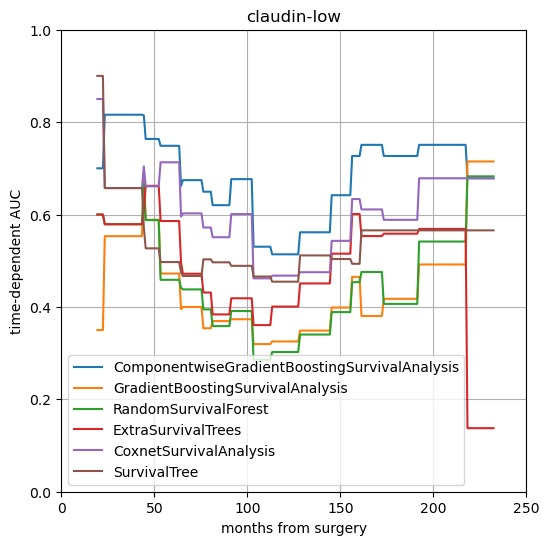

 83%|██████████████████████████████████████████████████████████████████▍             | 54/65 [2:16:37<32:36, 177.85s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
154
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.41535362 -0.7054993  -0.81844821 -0.21706318 -1.40935957 -1.82989845
 -0.01379103  1.08772996 -1.9557088  -1.33565679 -1.29133546 -2.39366125
 -0.77033704 -0.64989264 -1.65970302 -0.84424308 -1.30546006 -2.84499372
 -2.80669733 -2.0401319  -1.32711541 -2.20309212]
nan
[11.28135476 10.26838259 11.05715413 12.23561631 11.60925542  9.94247044
 12.71826948 14.32349835 10.70007439 11.70393909 10.49452527 10.27677398
 10.88219423 11.00315341 10.16619726 10.46287431 11.53035179  8.49128899
 10.15457076  9.50336723 10.27142535  8.62423094]
nan
[12.14434798 11.72630917 12.36596659 11.75427851 11.63675993 11.93901264
 12

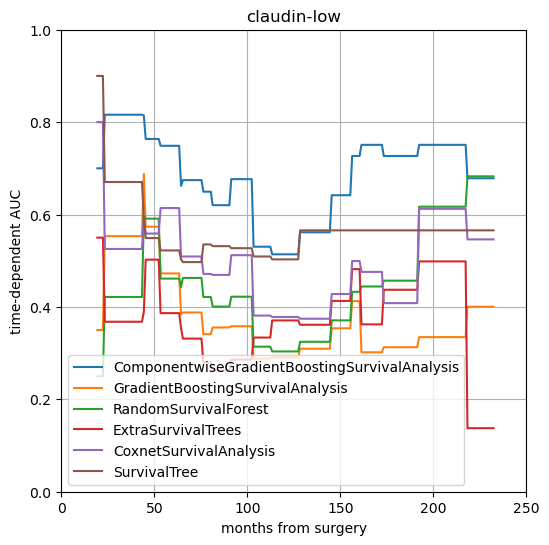

 85%|███████████████████████████████████████████████████████████████████▋            | 55/65 [2:19:36<29:41, 178.17s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
155
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.53967242 -1.09804528 -1.09549189 -0.3245752  -1.40918376 -1.99165168
 -0.25556411  1.04185701 -2.3293183  -1.61200895 -1.35625702 -2.55067953
 -1.00876794 -0.68876101 -1.79724825 -0.82387293 -1.29205209 -2.76590725
 -2.97924774 -2.18472956 -1.30529048 -2.18761418]
nan
[11.05419946  9.69625053 11.56064286 12.96532144 11.13236774 10.53197329
 12.10383264 14.16950096 11.1763672  11.39432642 10.18223576 10.56370578
 10.69774447 11.11236109 10.63291273 10.77822796 11.67702657  8.23752383
 10.02286143  9.04759721 10.27452896  9.06224879]
nan
[12.14786642 11.56026725 12.19849169 11.92932929 11.70060234 11.68660999
 12

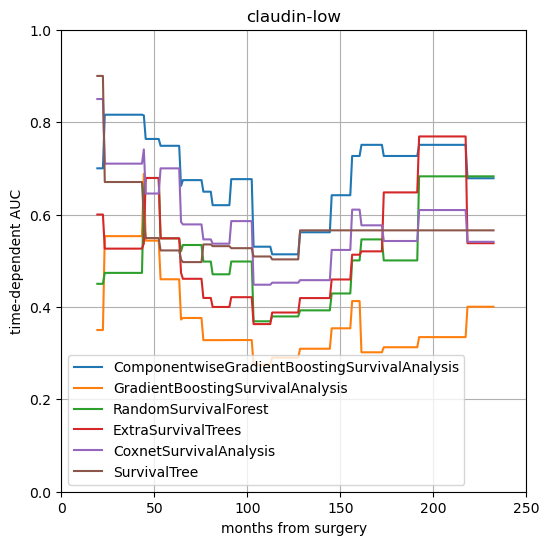

 86%|████████████████████████████████████████████████████████████████████▉           | 56/65 [2:22:39<26:57, 179.77s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
156
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.39800362 -0.808633   -0.84094676  0.81189161 -1.53649021 -2.21060702
 -0.10716298  2.28014902 -2.36908454 -1.5724459  -1.51678485 -2.50887548
 -1.0787684  -0.51921907 -1.85673472 -1.10191778 -1.29942089 -2.86798239
 -2.77189682 -2.44143472 -1.17809899 -1.95090216]
nan
[11.74458141  9.7836594  12.07663601 13.27628172 11.03683515 10.10882617
 11.68116408 13.75449481 10.52189031 11.2777902   9.98900899 10.12186277
 11.52416701 11.85591497 10.40668638 10.48861929 10.87444949  8.60567432
  9.18544168  9.50357821 10.73533485  8.96125069]
nan
[12.18594478 12.04362808 12.6029209  12.09185401 11.56670589 12.01513138
 12

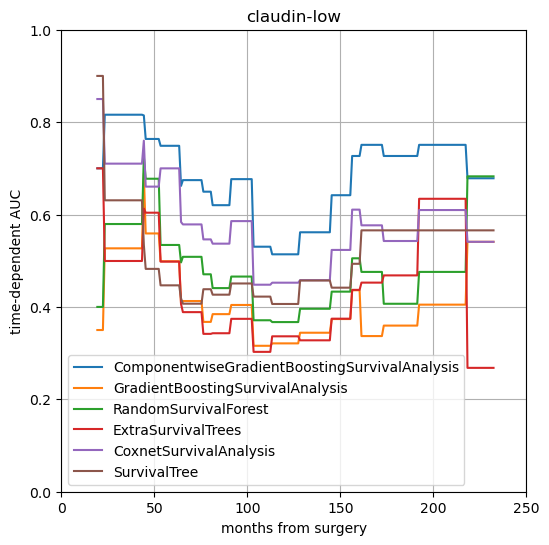

 88%|██████████████████████████████████████████████████████████████████████▏         | 57/65 [2:25:32<23:41, 177.69s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
157
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.41483659 -0.78008141 -0.8360139   0.81275401 -1.45296676 -2.19893083
 -0.11817001  2.28122669 -2.34877178 -1.54916238 -1.49312159 -2.54500175
 -1.02027882 -0.49582457 -1.82815014 -1.07550631 -1.25438312 -2.87154762
 -2.76195053 -2.44257963 -1.2008209  -1.94531911]
nan
[11.66063594  9.85531686 11.51069624 12.17246801 11.03735776  9.33733307
 12.60143161 13.26518644 10.77707694 11.00268366  9.89992929  9.84135069
 10.58707401 11.0886962  10.43348954 10.55105143 12.18662679  8.0506904
  9.65695834  9.55041086  9.91439314  8.56427472]
nan
[12.25498665 11.65995377 11.95800836 11.94359354 11.88544629 11.57757464
 12.

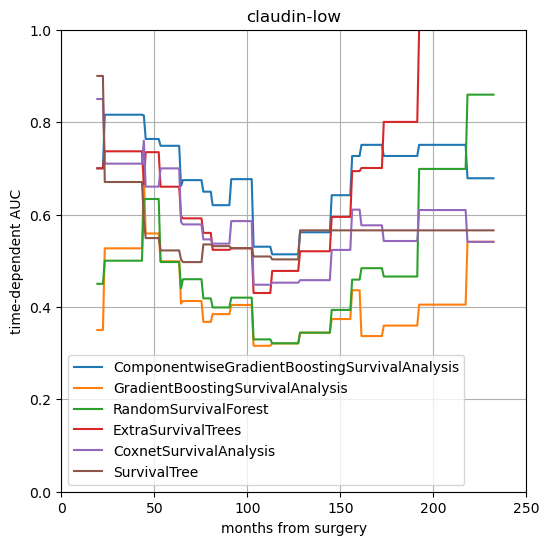

 89%|███████████████████████████████████████████████████████████████████████▍        | 58/65 [2:28:28<20:40, 177.15s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
158
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.38262178 -0.84858433 -0.84879838  0.78344851 -1.53781    -2.2271222
 -0.19015845  2.07663614 -2.31223099 -1.51826158 -1.36296357 -2.53354898
 -0.97779547 -0.38576947 -1.77082431 -1.13835375 -1.29969125 -2.85581505
 -2.76585089 -2.42527511 -1.1408869  -1.95385714]
nan
[11.55939115 10.1382111  11.98065195 12.29897282 10.99742708  9.67660119
 12.12602435 13.56099553 10.49292587 10.77506787  9.95818459 10.44821654
 10.84449013 11.96940771 10.82452943 10.27201594 12.35284484  8.11766665
 10.10899931  9.38504294 10.3962506   8.6380716 ]
nan
[12.18020413 11.82785417 12.19938703 11.81309568 11.83339991 11.72900447
 12.

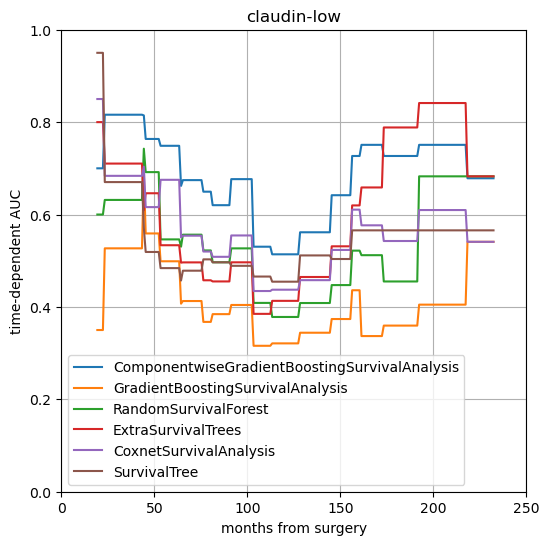

 91%|████████████████████████████████████████████████████████████████████████▌       | 59/65 [2:31:20<17:34, 175.69s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
159
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.45044117 -0.87995409 -0.95474449  0.69139312 -1.36953147 -2.37199662
 -0.31614762  2.1353108  -2.43322138 -1.65655814 -1.41040787 -2.55651046
 -1.03583306 -0.48006422 -1.78077255 -1.05698456 -1.19825977 -3.00775971
 -2.82247014 -2.37889327 -1.27797227 -1.99054284]
nan
[10.58430879  9.9300089  11.79168587 12.22334242 11.19161144  9.97322014
 11.57939028 14.57269176 10.74462578 10.45152099  9.22472865 10.71998101
 10.71967018 10.92686788 10.32091077 10.56214201 11.24385034  8.10440548
  9.44551646  9.02716072  9.99114794  8.9050083 ]
nan
[12.26817859 11.76975678 12.52298908 12.05360205 11.81182731 11.85589931
 12

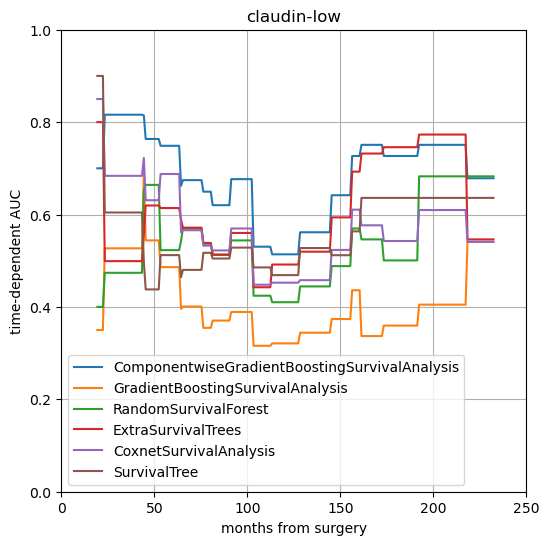

 92%|█████████████████████████████████████████████████████████████████████████▊      | 60/65 [2:34:14<14:35, 175.19s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
160
[ 0.21443622 -0.82101761  0.45242667  0.3312422   0.20490598 -0.40138704
  0.50701899  0.40996937  0.07384554  0.06711953 -0.76734141 -0.52192435
  0.43548399  0.33574345  0.29527012  0.00655918 -0.23261241 -0.68688535
 -0.12786754 -0.8525672  -0.75957178  0.11941314]
nan
[-1.39084837 -0.79039088 -0.86631469  0.77314762 -1.47192096 -2.29906548
 -0.21221033  2.24704559 -2.34897566 -1.58689457 -1.36004233 -2.59452026
 -0.9663501  -0.36226349 -1.80991286 -1.10952635 -1.25281245 -2.94186148
 -2.81937533 -2.39723705 -1.26175665 -1.92086638]
nan
[11.17564434 10.67672948 11.18081127 12.58698327 11.44612925  9.93873557
 12.17624454 14.4648758  10.6982509  10.76524469  9.76067299 10.18321938
 10.95282672 11.40406773 10.27351047 10.80901698 11.49775349  9.00337593
  9.60336828  9.30229074  9.74875666  8.61870409]
nan
[12.02312209 11.65722306 12.54577591 12.06747615 11.4403807  11.99469309
 12

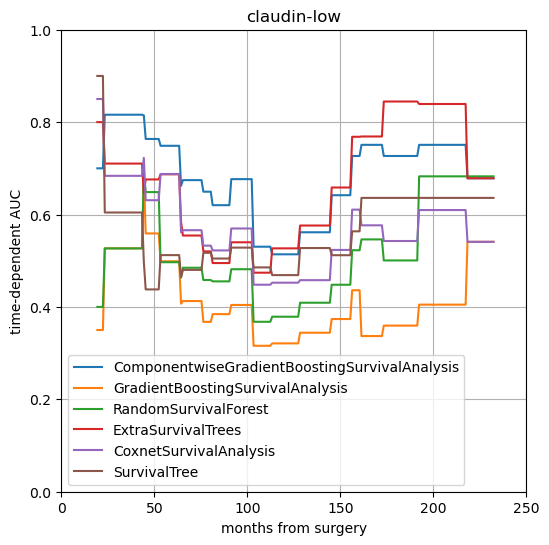

 94%|███████████████████████████████████████████████████████████████████████████     | 61/65 [2:37:08<11:38, 174.65s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
161
[ 0.18773393 -0.81795388  0.45031705  0.33123761  0.22401674 -0.40656464
  0.49848444  0.41613939  0.06494079  0.05778977 -0.77335116 -0.54229112
  0.41986995  0.35036537  0.27688204  0.00851574 -0.20187856 -0.65817545
 -0.07362503 -0.85202892 -0.75987488  0.11608737]
nan
[-1.73979703 -0.34022839 -0.85130788  1.13663609 -1.07519962 -2.37309008
  0.1655932   2.09495458 -2.68679546 -1.24133785 -1.54269986 -2.60401723
 -0.99249811 -0.77441083 -1.72789108 -0.97659233 -0.54166741 -2.62716034
 -2.40953685 -2.13709502 -1.93384293 -1.91530626]
nan
[11.25041436 10.36699126 12.33081281 12.43088003 10.85350816 10.2085479
 12.84233293 13.65082421 10.72774893 11.20464076  9.76554021  9.83714405
 11.38582559 12.24094672 10.89979396 10.87102092 12.03323539  8.6992888
  9.9909506   9.98486799 10.65271747  9.15226357]
nan
[12.0996931  11.5988397  12.26736343 12.07350852 11.52581041 11.97034227
 12.6

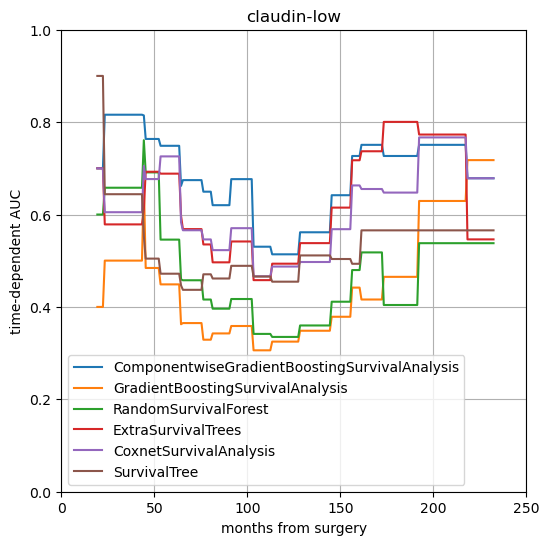

 95%|████████████████████████████████████████████████████████████████████████████▎   | 62/65 [2:40:03<08:44, 174.84s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
162
[ 0.18773393 -0.81795388  0.45031705  0.33123761  0.22401674 -0.40656464
  0.49848444  0.41613939  0.06494079  0.05778977 -0.77335116 -0.54229112
  0.41986995  0.35036537  0.27688204  0.00851574 -0.20187856 -0.65817545
 -0.07362503 -0.85202892 -0.75987488  0.11608737]
nan
[-1.66245997 -0.33910814 -0.78307163  1.2689221  -1.16014725 -2.39519558
  0.29640251  2.06492539 -2.65983715 -1.3043782  -1.54362782 -2.56675738
 -0.8595196  -0.59923405 -1.5857788  -0.76976049 -0.49289848 -2.62436642
 -2.44862199 -1.99772836 -1.88100917 -1.9416453 ]
nan
[11.28846202 10.29657598 12.31495322 12.96734262 11.29457021 10.24208871
 12.32712177 14.30043683 11.11266467 11.70447424  9.9854409  10.18871833
 11.21652068 11.77461246 10.84884889 10.52238942 11.78830004  9.18850766
 10.08050254  9.55350202 10.10868383  9.25880821]
nan
[11.98684823 11.59954085 12.23797488 12.31553237 11.80235472 11.76656078
 12

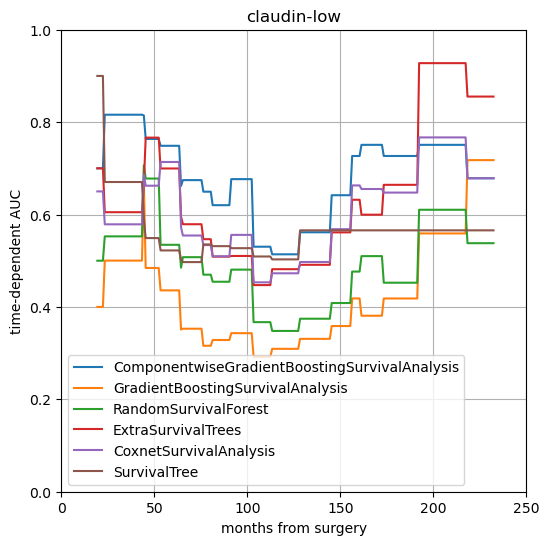

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 63/65 [2:42:57<05:49, 174.69s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
163
[ 0.19145501 -0.8184229   0.44650912  0.32383048  0.22076853 -0.40271568
  0.50287965  0.41554044  0.06180425  0.05292767 -0.77430414 -0.54148228
  0.42134905  0.35221198  0.28279911  0.00740543 -0.20235585 -0.64929788
 -0.0793291  -0.84498731 -0.76003298  0.11881911]
nan
[-1.60532161 -0.14136265 -0.69666205  1.16431008 -1.15077111 -2.21179506
  0.15921957  2.24247267 -2.51248963 -1.31515277 -1.57058255 -2.53571108
 -1.04000324 -0.69218122 -1.49980978 -0.95564623 -0.5840546  -2.56662974
 -2.37833906 -1.99226026 -1.6613822  -1.8086245 ]
nan
[11.08090971 10.14176375 12.59573762 11.81642159 11.45949177 10.23377188
 12.43980212 14.40940585 10.28544626 11.20916619 10.17345976 10.76152638
 10.7200237  12.15687176 11.26334858 10.77867153 11.25851853  9.00996234
 10.04525291  9.72990327 10.20163381  9.3086299 ]
nan
[12.31899737 11.94645223 12.53508141 11.8496675  11.67588883 12.16870988
 12

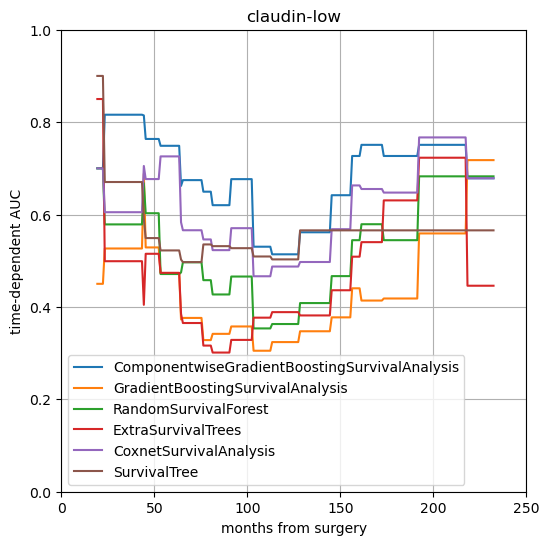

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 64/65 [2:45:49<02:53, 173.84s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
164
[ 0.19145501 -0.8184229   0.44650912  0.32383048  0.22076853 -0.40271568
  0.50287965  0.41554044  0.06180425  0.05292767 -0.77430414 -0.54148228
  0.42134905  0.35221198  0.28279911  0.00740543 -0.20235585 -0.64929788
 -0.0793291  -0.84498731 -0.76003298  0.11881911]
nan
[-1.69882751 -0.41815338 -0.89410647  1.00754622 -1.07771276 -2.27510759
  0.30204996  2.04512815 -2.63210386 -1.42055003 -1.60474995 -2.56170042
 -0.933118   -0.50569475 -1.65092166 -0.88028759 -0.77008401 -2.51376404
 -2.48374775 -2.11693735 -1.75772407 -1.91038664]
nan
[10.78353344 10.41635061 11.48375008 12.5847309  11.52757521  9.6853944
 12.38539877 14.38822627 10.8228321  11.09711404  9.96006087 11.13449806
 11.36572356 12.26314286 11.26975636 10.81130572 11.85055369  9.16543806
  9.49585239 10.09936988 10.07835857  9.29263212]
nan
[11.98117084 12.08436963 12.82106371 12.60814706 11.99442686 11.86817176
 12.

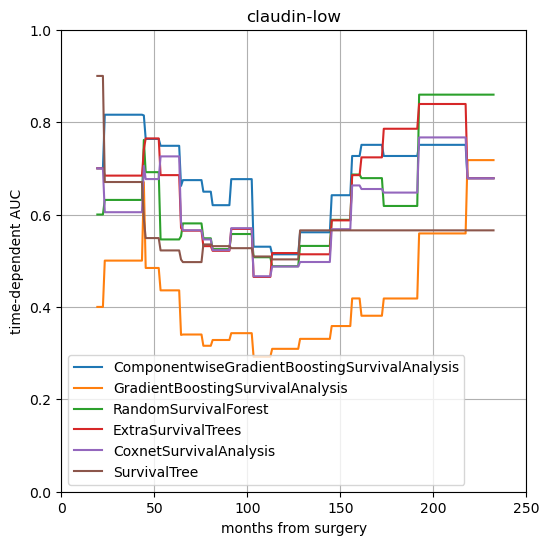

100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [2:48:44<00:00, 155.77s/it]


In [12]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(100,165, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "NEWpreprocess4numeric_Incpca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "NEWpreprocess4numeric_Incpca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "NEWpreprocess4numeric_Incpca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "NEWpreprocess4numeric_Incpca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                    ),
                ),
            ],
        },
        {
            "model_name": CoxnetSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "NEWpreprocess4numeric_Incpca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    CoxnetSurvivalAnalysis().__class__.__name__,
                    CoxnetSurvivalAnalysis(n_alphas=10000, fit_baseline_model=True),
                ),
            ],
        },
        {
            "model_name": SurvivalTree().__class__.__name__,
            "preprocess_name": "NEWpreprocess4numeric_Incpca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    SurvivalTree().__class__.__name__,
                    SurvivalTree(random_state=config.SEED),
                ),
            ],
        },
    ]
    loop_exec()

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
[-0.66462255  2.21593867 -1.27814462  1.45696547  2.76449852  2.24821757
  0.99409939 -0.20190022  1.84563881 -1.4872144  -1.10543151 -0.22740884
 -2.86862002 -2.4994759   3.28540206  2.06111759 -0.85222293 -2.29601687
 -1.24969264 -2.80664965  2.56744705 -0.203028  ]
nan


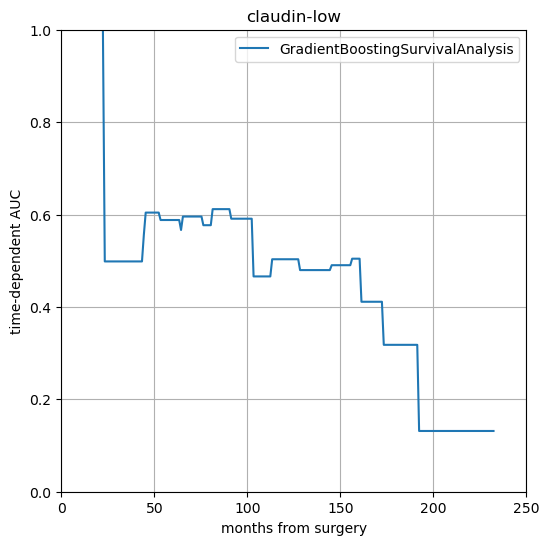

[ 0.81910423 -0.58484384 -0.95913604 -2.3018112  -1.56219809  0.93250135
 -0.87327243  0.18564002  1.24442024 -1.60999113 -1.11712956  2.30353038
 -1.07234573 -0.56338571  0.997924    0.19621639 -0.22702751 -0.58399148
 -0.59322856 -0.40849774  0.150178    0.34805239 -1.04583902  0.01108529
 -1.15205004 -1.0375639  -1.40658384  0.36876524 -1.10959613 -0.15994638
 -0.75289425  1.41856061  0.19988859  0.42653582 -1.91445271  1.0826289
  1.13647902  0.68285639 -0.91364155 -0.58096935 -0.15365437  1.90693158
 -1.1438139   0.81236534  0.2808322   1.00886652  2.19417591 -0.06582985
  1.79697927  0.66783837 -0.53980943  0.43501183 -0.23700754  0.20409208
  1.14055457  0.7487561   0.83525018  0.32674783 -0.16347896  0.54179485
  0.31249431  0.67059009  1.06305821  0.52812711 -1.06762411 -0.38313419
 -0.74068467 -0.07845838 -1.64923572]
0.553528597095901


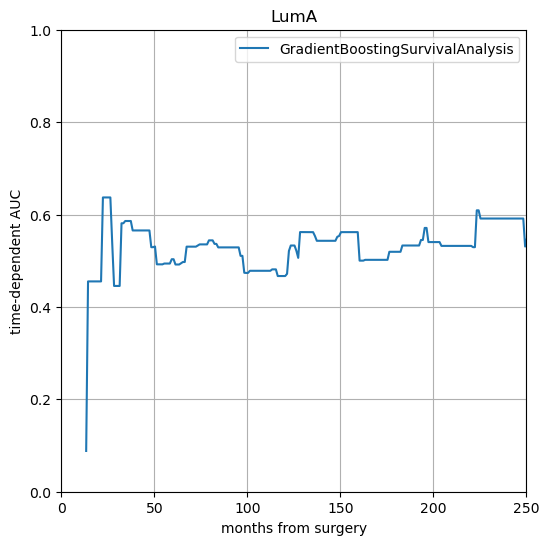

[ 0.21272752 -0.32215311  0.16630748  1.95577856  1.73925862  1.10195455
 -2.35054023 -0.77763882  0.22647233 -0.83464356 -1.2345083  -0.52626951
  0.30845814  1.25271463  2.14934873  0.12254638  0.09900431 -0.95840483
 -0.95572728  0.18676354 -1.78891759  2.06126708 -2.20312203  1.02742418
 -0.52351517 -0.55597651 -1.24912631 -0.56826564  1.00977876 -0.88503086
  1.18006631 -0.59179171 -0.61821216  0.56563572  1.23211081 -0.73985139
  0.4253579   1.13998159  1.36037395 -2.1209076   0.96268123  1.31579767
  1.9802607  -1.4817713  -1.96119203 -2.48570887 -1.00842367 -0.51876672]
0.5722118189801356


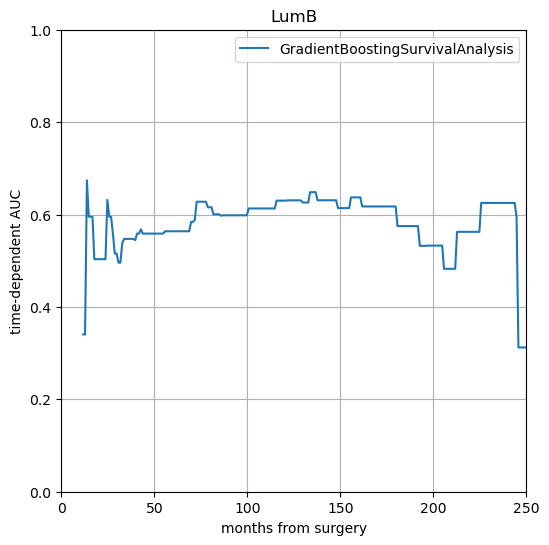

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


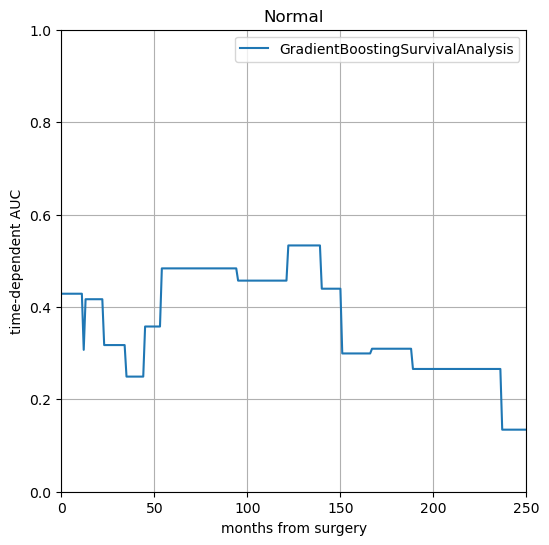

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


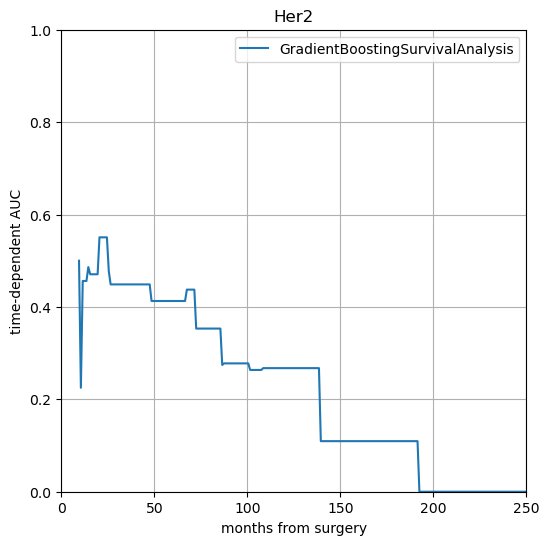

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


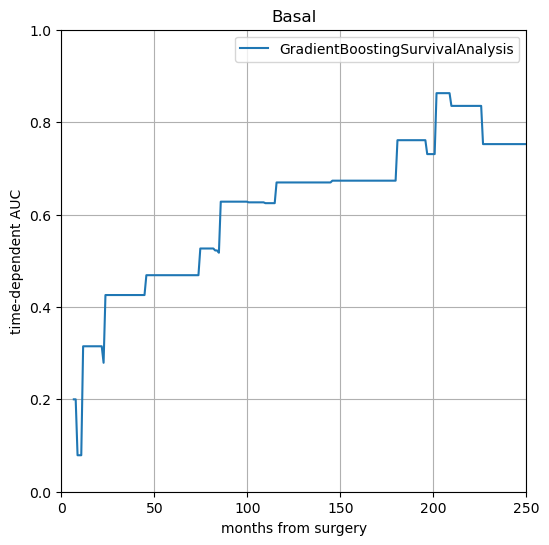

data pkl file dose not exist


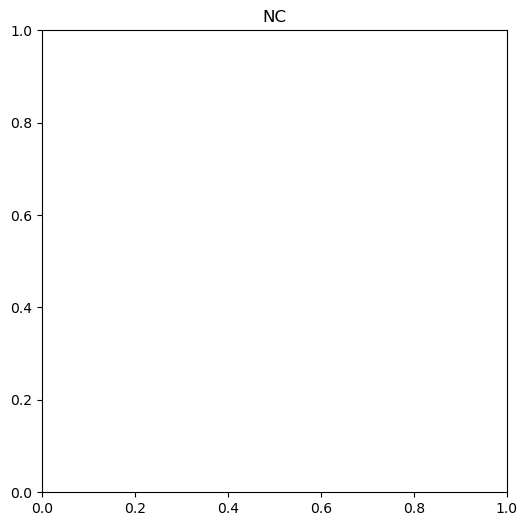

 20%|█████████████████                                                                    | 1/5 [00:15<01:01, 15.27s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
26
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


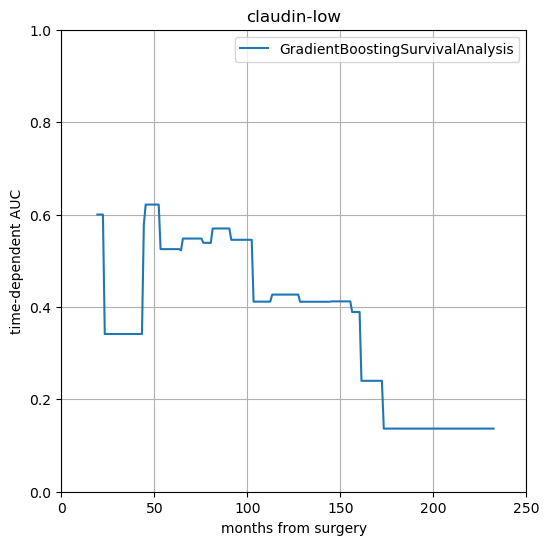

[ 1.1647718  -0.53949264  0.4438762  -1.70980832 -1.54941269  0.80077984
 -1.05099495 -0.15179658  0.84401006 -0.66780516 -1.50551816  1.78093075
 -1.00710227  0.03946767  0.84303905  0.26519874  0.25401803 -0.16249501
 -0.51811747 -0.31855123 -0.09393167  0.62374825 -0.3443578   0.52019119
 -1.37815232 -1.069515   -1.03086422  0.38275894 -1.82158682 -1.08354366
 -0.72341752  1.55322727  0.70841345 -0.55834207 -2.09714071  2.1565477
  0.5031976   0.60478965 -0.76546874  0.43511602  0.30146675  1.14214909
 -0.87733737  0.60440981  1.28289439  0.30904071  1.27869659 -0.0532275
  1.69848755  0.93627411  0.09184524  1.09739257 -0.0333933   0.035852
  0.78272025  0.11357761  1.33186593 -0.26126753  0.02731512 -1.26425058
  0.2255833   0.28592991  1.3726662  -0.05928041 -1.64546081 -0.30889653
 -0.30130764 -0.91933342 -1.42699983]
0.6958686922070627


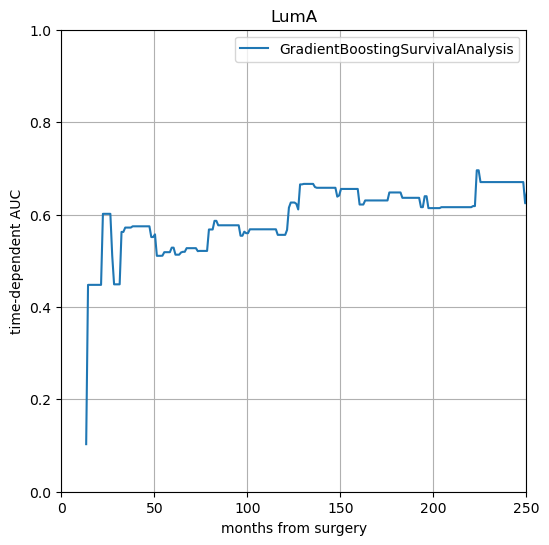

[-0.29816095 -1.37550105 -0.02853549  2.0114589   1.66393582  1.22816119
 -1.48350454 -0.20510831  0.1196093  -0.77380879 -0.46629575  0.06393958
  0.37779217  1.08301354  2.22800792  0.1782986  -0.10879887 -0.26679583
 -1.839408    1.84075266 -2.54185915  3.31476619 -2.05054501  0.86165138
 -0.99669737  0.66222409 -1.9252856  -1.2782884   1.57879547 -1.1672371
  1.55295157 -0.56703377 -0.0603211  -0.39607197 -0.23529291 -0.92975854
  0.91809389  1.3626946   0.04324979 -1.21527289  0.43240992  1.22368563
  1.25254924 -2.38733063 -3.8637504  -3.16976536 -1.81435538 -1.34121186]
0.579269146966861


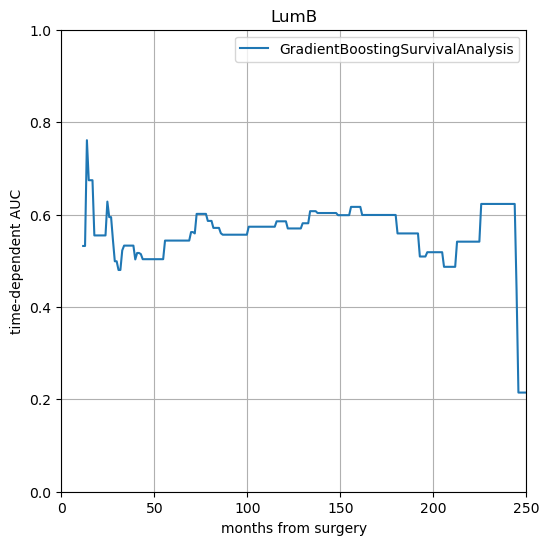

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


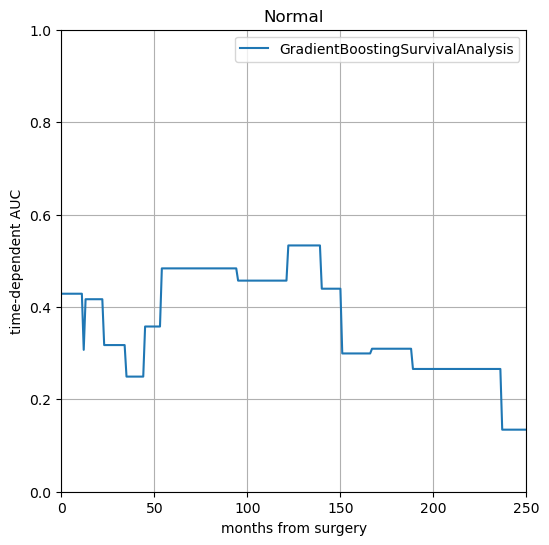

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


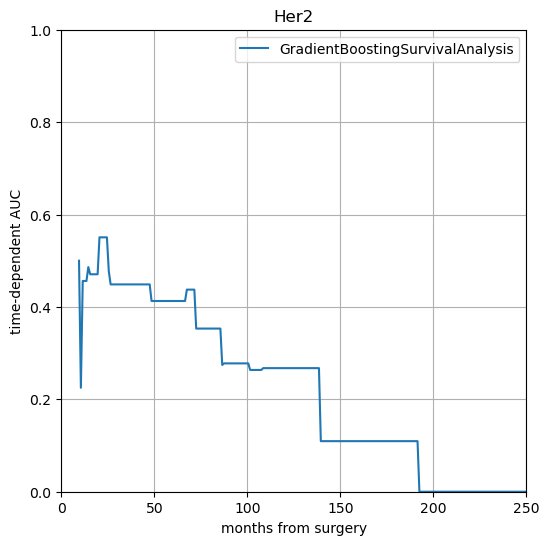

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


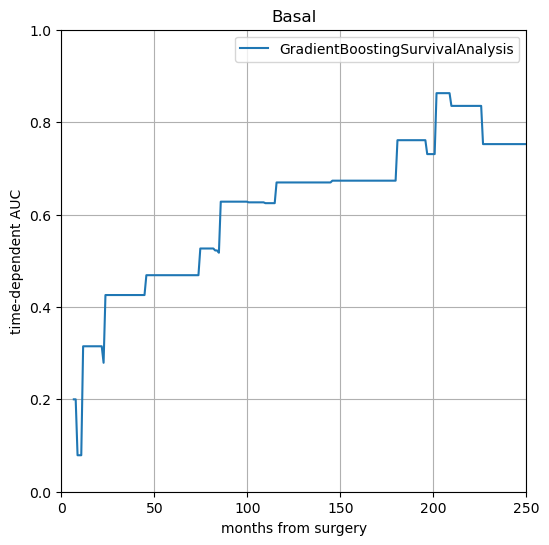

data pkl file dose not exist


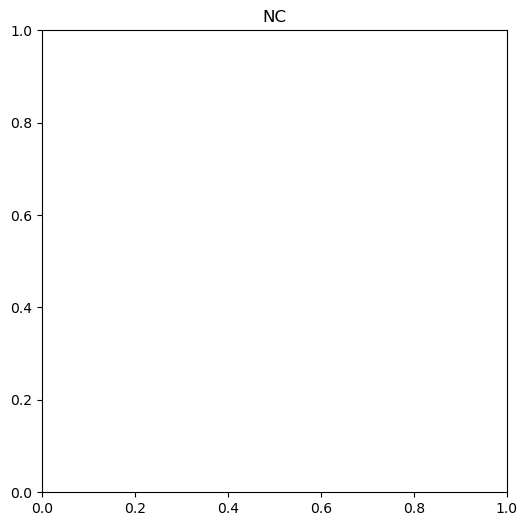

 40%|██████████████████████████████████                                                   | 2/5 [00:25<00:36, 12.19s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
27
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


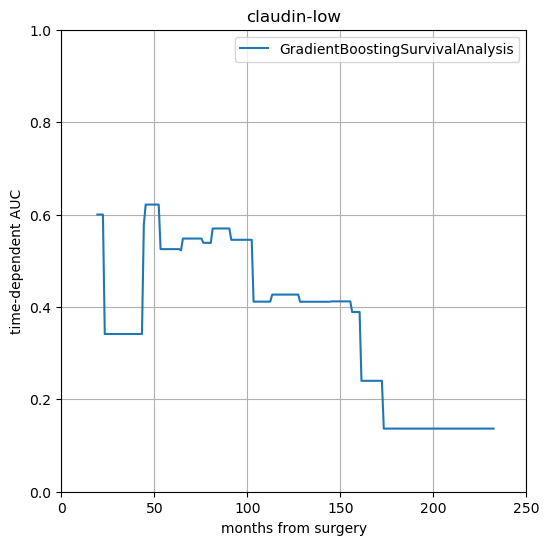

[ 1.1647718  -0.53949264  0.4438762  -1.70980832 -1.54941269  0.80077984
 -1.05099495 -0.15179658  0.84401006 -0.66780516 -1.50551816  1.78093075
 -1.00710227  0.03946767  0.84303905  0.26519874  0.25401803 -0.16249501
 -0.51811747 -0.31855123 -0.09393167  0.62374825 -0.3443578   0.52019119
 -1.37815232 -1.069515   -1.03086422  0.38275894 -1.82158682 -1.08354366
 -0.72341752  1.55322727  0.70841345 -0.55834207 -2.09714071  2.1565477
  0.5031976   0.60478965 -0.76546874  0.43511602  0.30146675  1.14214909
 -0.87733737  0.60440981  1.28289439  0.30904071  1.27869659 -0.0532275
  1.69848755  0.93627411  0.09184524  1.09739257 -0.0333933   0.035852
  0.78272025  0.11357761  1.33186593 -0.26126753  0.02731512 -1.26425058
  0.2255833   0.28592991  1.3726662  -0.05928041 -1.64546081 -0.30889653
 -0.30130764 -0.91933342 -1.42699983]
0.6958686922070627


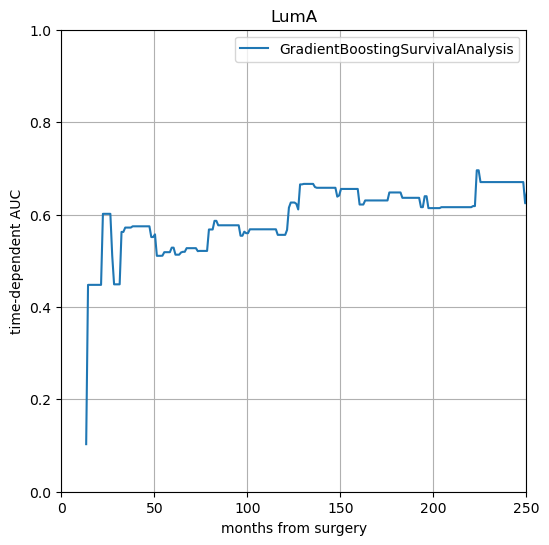

[ 1.64428977 -0.76103864 -0.18748068  2.86509284  1.58245787  0.74890393
 -1.49545217 -0.17286058  0.21275273 -1.02420218 -0.37391356  0.12114964
  0.12581265  1.8086692   2.4658682   0.67607998 -0.21459549 -0.1153092
 -1.79984337  1.27224351 -2.06345232  2.02747614 -1.91230294  0.81348403
  0.18964712 -0.24424723 -1.61392793 -1.08166326  1.56024975 -2.08485317
  0.88786799 -0.59899862 -1.35182685 -0.80349519 -0.16554772 -1.33823589
  0.82039733  1.74852824  0.10308666 -1.17578626  0.3115619   2.33225764
  0.8845358  -2.00924386 -2.44307842 -3.82862556 -1.37270663 -2.10760655]
0.5687912246744259


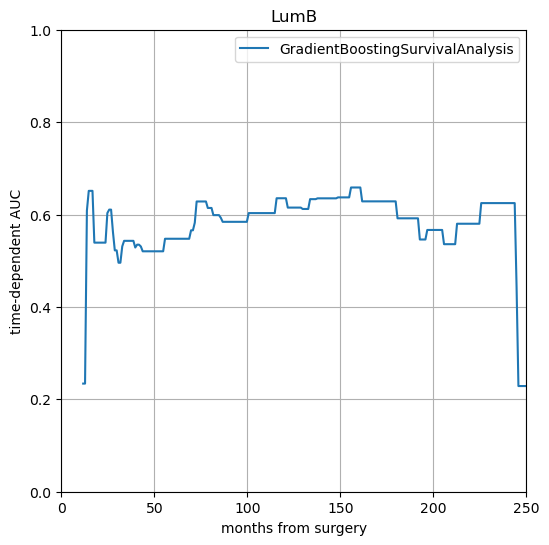

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


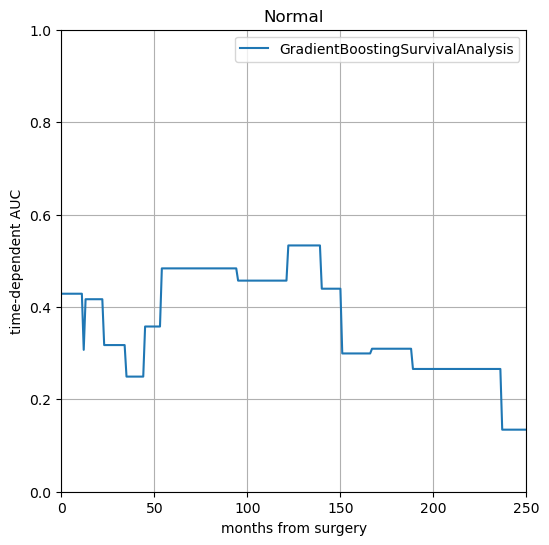

[ 1.34919543 -1.18389027 -1.26579599  0.17816005 -1.16754808 -2.17567451
  3.32885131  0.31683394  3.09045133  2.14762935 -0.80387847 -1.92601247
  0.36578174  2.38212972  1.93157096  0.36036759  0.2851842   0.39983361
 -1.88300049 -0.00970015  3.05880152 -0.18001785  0.72923806]
0.47576321532403243


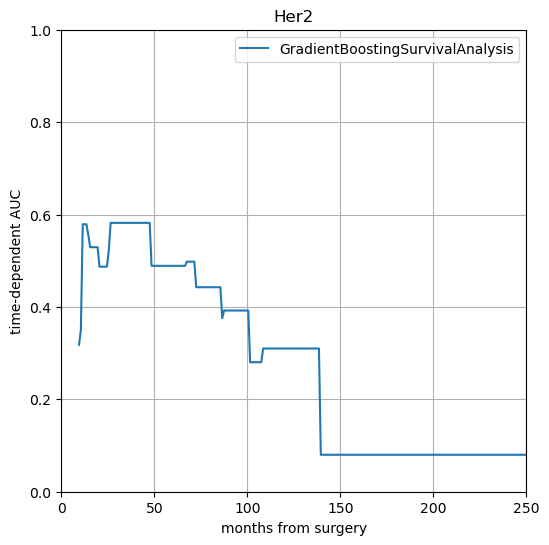

[ 0.68846474 -1.19487744  1.32054531 -0.83613485  0.27150456  2.41322182
  2.27144126 -0.06437624  1.17037912  4.43683958  1.34645155  0.63452683
  2.78674555 -0.94719184 -0.59278584 -2.99379802 -0.07359785 -0.72431269
 -2.5113434  -1.40327955  2.59110329]
0.5842343964857056


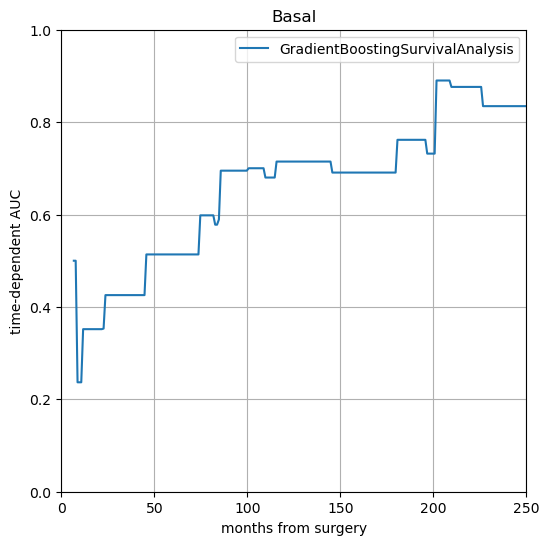

data pkl file dose not exist


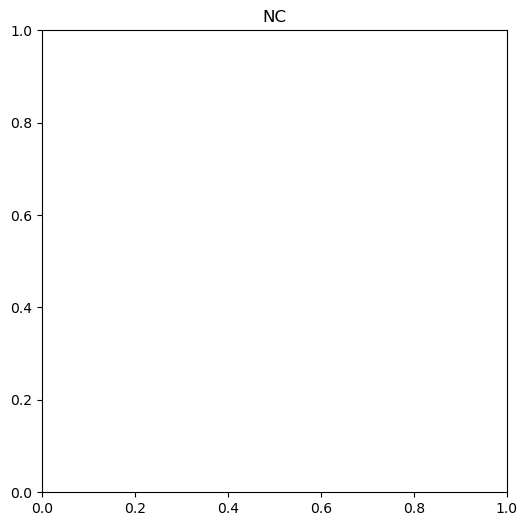

 60%|███████████████████████████████████████████████████                                  | 3/5 [00:35<00:22, 11.31s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
28
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


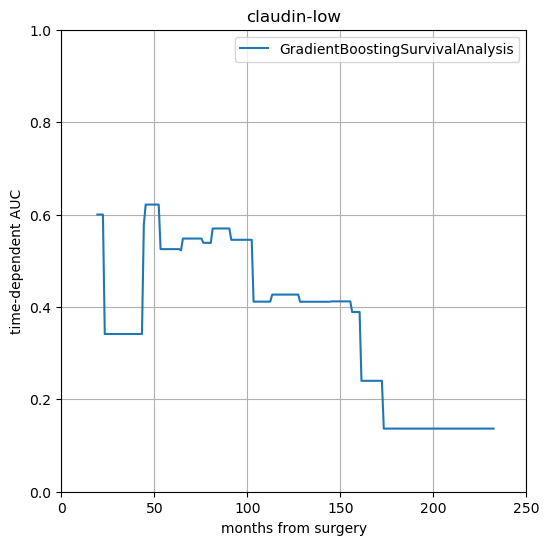

[ 1.10617615 -0.45265927 -0.33802761 -1.46762414 -0.78241575  0.9322115
 -0.49883611 -0.09881251  1.25147795 -0.72838705 -0.50673283  0.85207273
 -1.48214367  0.11318232  1.25221311  0.44299263 -0.21762745  0.34314124
 -0.99491338 -0.49610932 -0.16394825  2.05616793 -0.56744247  0.30301445
 -1.39432312 -1.17714174 -1.32066168  0.09994219 -1.66033633 -0.62327763
 -0.60300316  0.56556577  0.79157991  0.25088545 -2.16851341  2.28507918
  0.74070083  0.10630519 -1.01441445 -0.01415444 -1.32749842  1.11925885
 -1.33491181  0.40356067  0.8768704   0.36878823  1.60011571 -0.25887343
  2.29530142  0.89173059 -0.16457136  1.13094319  0.12744685  0.10523241
  0.87857831  0.13899911  1.05381946  0.26114086 -0.15444825 -1.01459136
  0.42675496  0.34200874  1.35455139 -0.0569336  -1.37614187 -0.34218511
 -0.15855039 -0.66421203 -1.76733485]
0.5701836961105938


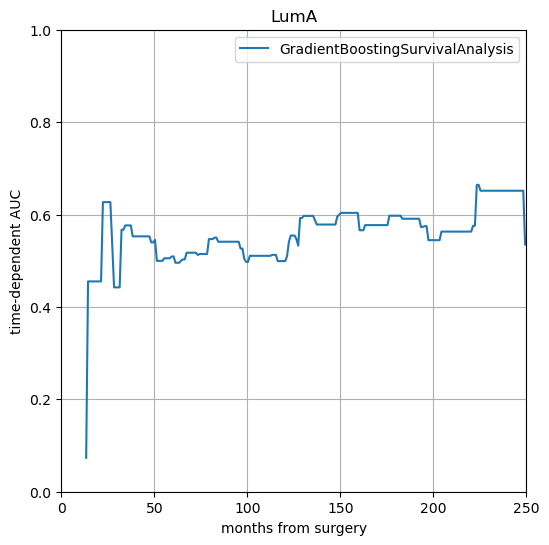

[ 1.7191497  -0.66685647  0.76327452  2.51668866  2.30457919  0.29871587
 -1.1801239   1.0581622   0.34696621 -0.76090491  0.38891632  1.30442354
 -0.00454786  1.97410805  3.32520226  0.62170532  0.52602647  0.66097014
 -2.18166108  0.58514658 -1.90139993  2.95561451 -2.11335523  0.7000122
 -0.57868006 -0.34009371 -1.98021669 -0.89469939  1.37176777 -0.97544648
  1.29085155 -0.86357976 -0.43354325 -0.44701206  0.03258007 -1.43988344
  0.55481938  1.03372136 -0.10825144 -2.1203632   0.28495271  0.54289512
  0.47423777 -2.32884037 -2.26010367 -3.2580263  -1.545901   -1.43237223]
0.5202575052710318


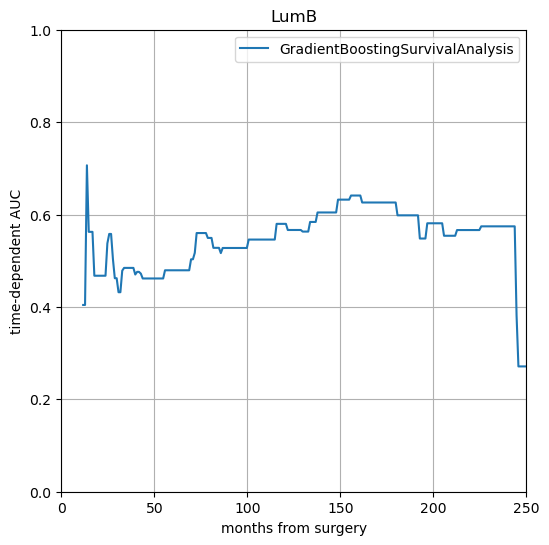

[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625


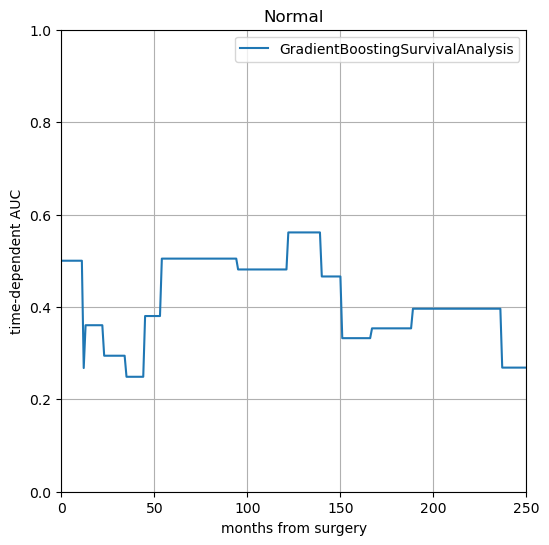

[ 1.77639523 -1.91988973 -2.27689743  0.6832325  -1.76618637 -0.73427336
  2.8247425   1.04227895  5.32478763  2.04341862 -0.62136854 -1.0258449
 -0.69842208  1.29011672  0.42880546 -0.03751928 -1.14721911  0.60118158
 -1.45129288  0.51926737  2.82664289  0.08259001  1.41606465]
0.4996444340372556


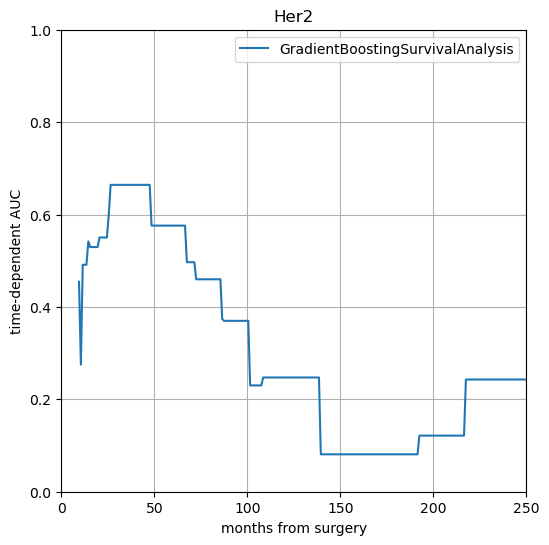

[ 0.74803148 -0.56913885  1.6167754  -0.65310983  0.88290777  2.30777841
  1.99164417 -0.16008121  2.40059367  4.60402103  0.76540465  1.15300215
  2.95152704 -1.31739986 -1.03128464 -2.84901239 -0.45378834 -0.63798402
 -2.88119586 -0.83699931  1.80418106]
0.6116465732232289


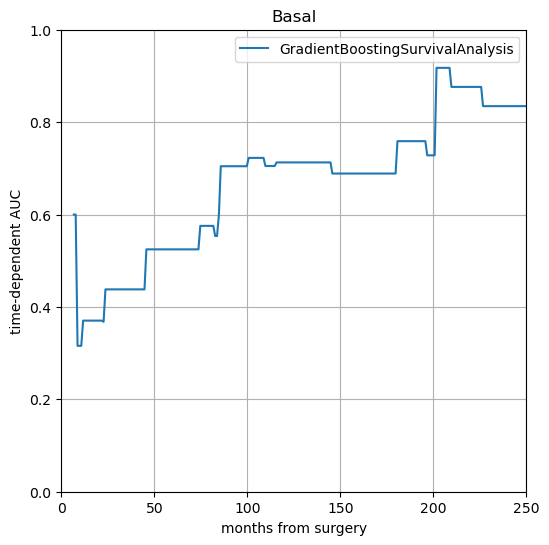

data pkl file dose not exist


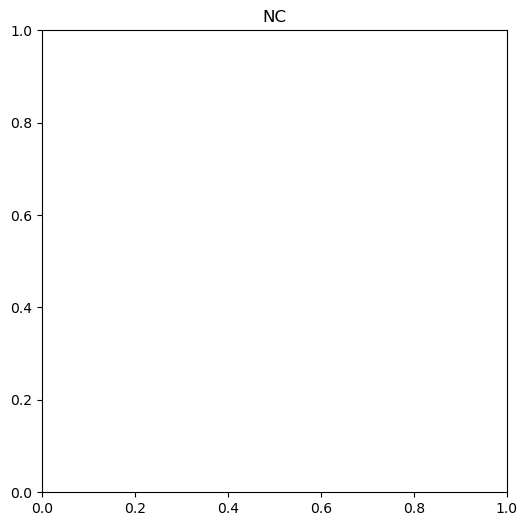

 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:46<00:11, 11.04s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29
[-0.34636442  1.62586715 -2.02126814  4.04507094  3.72910822  2.34089132
 -0.80610216 -0.56713351  1.42826993 -2.59888449 -0.96971278  2.0356115
 -2.01875026 -1.81423812 -0.5431672   1.43170485  0.35765888 -2.80588969
 -2.16456147 -2.86870926  1.11709408 -1.37231273]
nan


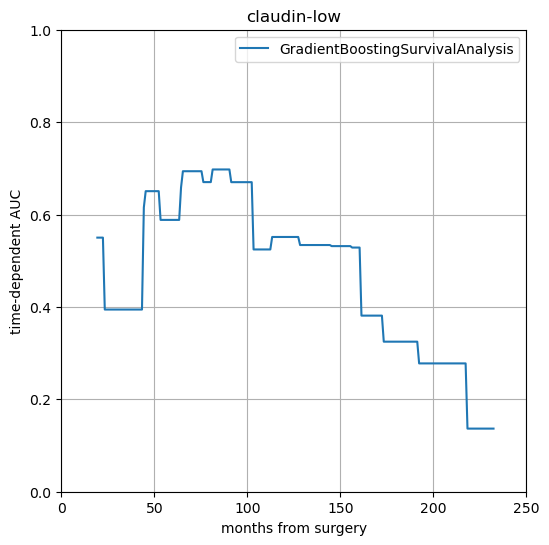

[ 0.64521463 -0.52241969  0.04728249 -1.01568112 -0.26024465  1.34062726
 -1.9349465   0.05875958  1.06386117 -0.69007189 -1.47980258  0.43130659
 -1.43682311  0.24390079  1.17122283  0.72739486 -0.0082983   0.96345143
 -0.73803142 -0.39078375  0.43789474  2.27166809 -0.0388123   0.81503273
 -1.31511735 -0.92543374 -0.96198261  0.11898892 -1.24110203 -0.95495709
 -1.86110433  0.12349721 -0.47840029  0.32687209 -1.815693    2.02388087
  0.93929318  0.41631335 -0.49117073 -0.04247961 -1.83047948  1.16788909
 -1.29839885  0.16700038  1.9062899  -0.61349272  2.26955292 -0.33012923
  1.66347965  0.81227146 -0.74939565  0.9332191   0.1907329   0.37873227
 -1.03679664 -0.72849339  0.10599012  0.75238863 -0.34999436 -1.23180975
  0.64122843  0.56184867  1.39511169  0.02824375 -0.87006382 -0.66031017
  0.12578398  0.66004087 -1.21584388]
0.3773361492970579


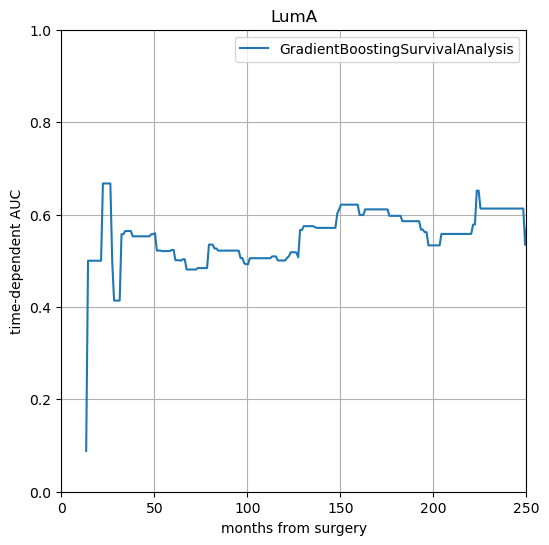

[ 1.41005409  0.01457816  0.66076733  1.52008481  2.16978395 -0.98747827
 -1.12893741  1.33107485  0.57772064 -2.2825947   0.81828288  0.21847421
  0.10310342  2.18177939  2.51747886  0.38334719 -1.45513732  1.87129602
 -1.51401488  0.42463384 -0.83289299  1.06115972 -1.22667311 -0.07324632
 -0.98753913  0.40890379 -1.19338128 -1.86081408  2.05075722  0.4683888
  0.85545663 -1.15977101 -0.93314836 -0.68256008 -0.56411626 -1.51764937
  0.5002916  -0.84389015 -0.43454741 -1.2554608  -1.16385017  2.10999738
  0.2170464  -1.43083836 -0.32663552 -4.40467802 -1.19392753 -2.34677   ]
0.5749231002111117


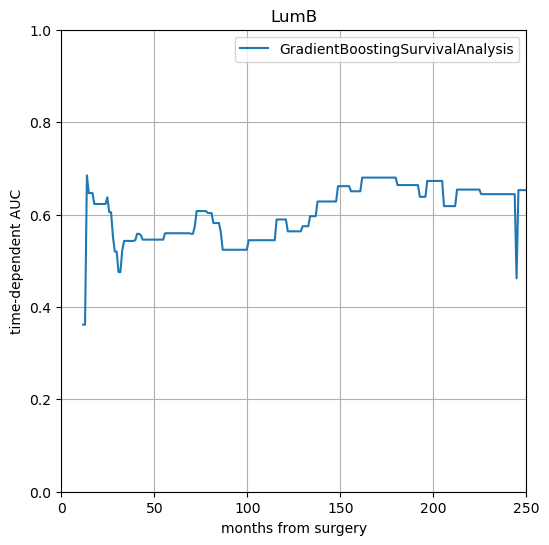

[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625


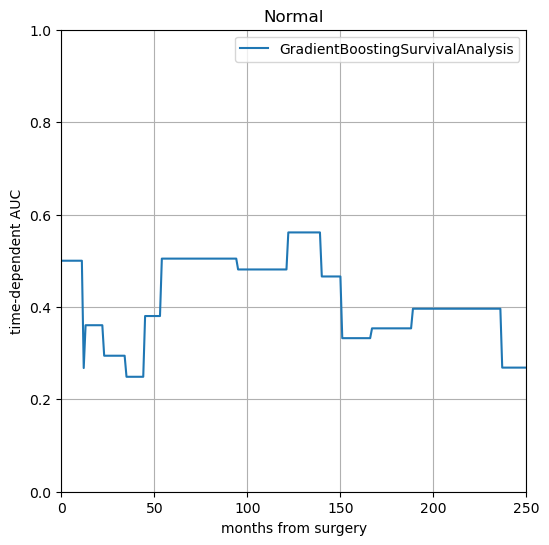

[ 1.77639523 -1.91988973 -2.27689743  0.6832325  -1.76618637 -0.73427336
  2.8247425   1.04227895  5.32478763  2.04341862 -0.62136854 -1.0258449
 -0.69842208  1.29011672  0.42880546 -0.03751928 -1.14721911  0.60118158
 -1.45129288  0.51926737  2.82664289  0.08259001  1.41606465]
0.4996444340372556


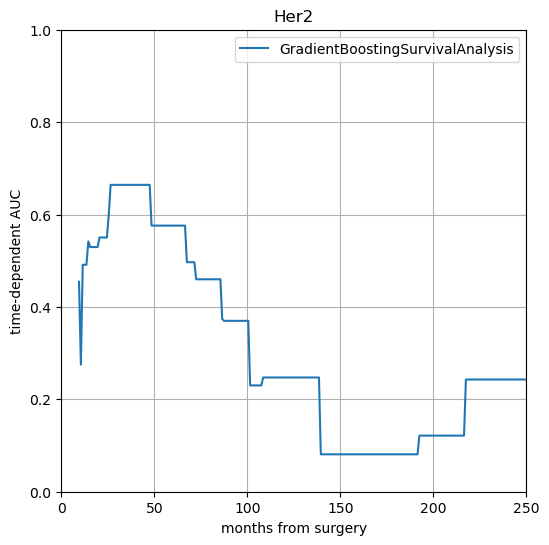

[ 0.74803148 -0.56913885  1.6167754  -0.65310983  0.88290777  2.30777841
  1.99164417 -0.16008121  2.40059367  4.60402103  0.76540465  1.15300215
  2.95152704 -1.31739986 -1.03128464 -2.84901239 -0.45378834 -0.63798402
 -2.88119586 -0.83699931  1.80418106]
0.6116465732232289


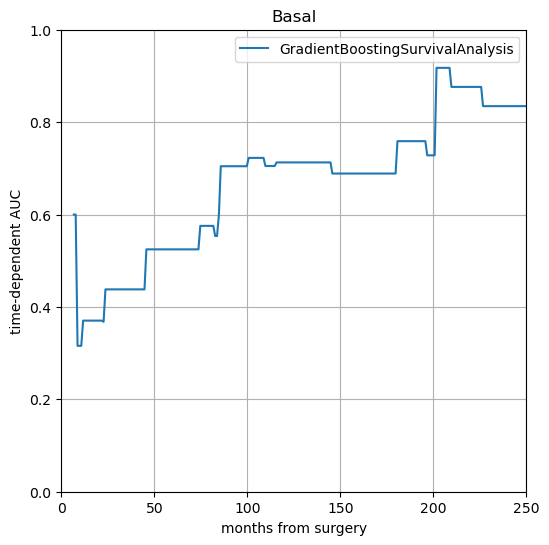

data pkl file dose not exist


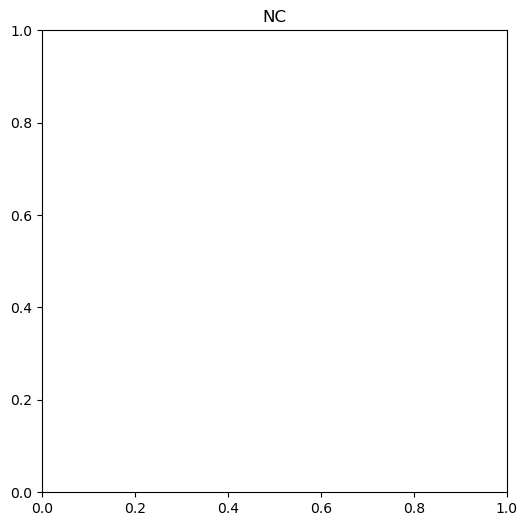

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.27s/it]


In [15]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 30, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__ + "_2",
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

In [85]:
#AUC_meanの最大値取り出す
max = 0
for i in range(2,5,1):
    c = pd.read_csv(config.INTERIM_MODELS_RECURRENCE_DIR + '/CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_Incpca{0}/result.csv'.format(i), index_col=0)
    c2 = c.iloc[[2],]
    s = c2.max(axis = 1)
    ss = float(s.values)
    if ss >= max:
        max = ss
        f = i
print("Incpca:"+ str(i)) 
print(max)

4
Incpca:4
0.622


In [51]:
c2 = c.iloc[[2],]
c2

ComponentwiseGradientBoostingSurvivalAnalysis  \
AUC mean                                          0.549   

          GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
AUC mean                             0.507                 0.545   

          ExtraSurvivalTrees  CoxnetSurvivalAnalysis  SurvivalTree  
AUC mean               0.493                   0.586         0.568

In [79]:
float(s.values)

array([0.586])

In [53]:
s = c2.max(axis = 1)
s
#s_max = s.values
#print(s_max)

AUC mean    0.586
dtype: float64

<bound method NDFrame._add_numeric_operations.<locals>.max of Unnamed: 0                                       AUC mean
ComponentwiseGradientBoostingSurvivalAnalysis       0.549
GradientBoostingSurvivalAnalysis                    0.507
RandomSurvivalForest                                0.545
ExtraSurvivalTrees                                  0.493
CoxnetSurvivalAnalysis                              0.586
SurvivalTree                                        0.568
Name: 2, dtype: object>

In [17]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

In [11]:
X.shape

(22, 5)

In [12]:
print("LumA")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("LumB")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Her2")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)


print("claudin-low")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Basal")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

LumA


array([0.07999636, 0.03472473, 0.0332846 , 0.0229756 , 0.02121804,
       0.01845694, 0.0170286 , 0.01643943, 0.01480088])

LumB


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

Her2


array([0.13357718, 0.03192168, 0.02959312, 0.02293049, 0.02194096,
       0.02005952])

claudin-low


array([0.0769747 , 0.05560789, 0.04645281, 0.04078616, 0.03282703])

Basal


array([0.07552512, 0.04812878, 0.03409818, 0.02698724, 0.02222222,
       0.02094353, 0.01901346, 0.01553277])

In [12]:
print("25")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("50")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("77")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca75/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

25


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

50


FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl'

In [1]:
x = np.arange(0, len(pipe[-1].explained_variance_ratio_))
y = pipe[-1].explained_variance_ratio_
plt.title("Matplotlib demo")
plt.xlabel("x axis caption")
plt.ylabel("y axis caption")
# plt.plot(x, y)
plt.plot([0] + list(np.cumsum(y)), "-")
plt.show()

NameError: name 'np' is not defined